# 1. Measure and improve

How do we know that search engine's quality improved (or at least haven't deteriorated) because of our changes?

All we need is a way to ***evaluate*** our search engine. We will consider some of the popular evaluation techniques:

1. Mean Average Precision
2. 11-Point Interpolated Average
3. Normalized Discounted Cumulative Gain (NDCG)
4. pFound

<!--We will apply them in the context of ranking with language models and will compare two ways of smoothing: additive and Jelinek-Mercer smoothing.
-->

It's best to go through the [book](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf) *chapter 8*, concretely, *8.4* to understand the key concepts of this lab. Here we will only present some excerpts from it.

## 1.1. [10] Mean Average Precision

The most standard metric among the TREC community is *Mean Average Precision* *(MAP)*, which provides a single-figure measure of quality across recall levels. Among evaluation measures, MAP has been shown to have especially good discrimination and stability. For a single information need, Average Precision is the average of the precision value obtained for the set of top $k$ documents existing
after each relevant document is retrieved, and this value is then averaged over information needs (queries). 
Assume we have a bucket $Q$ of queries $q_j\in Q$.
If the set of **relevant documents** for an information need (query) $q_j$ is {d<sub>1</sub>, . . . d<sub>m<sub>j</sub></sub>} and R<sub>jk</sub> is the set of ranked retrieval results from the top result until you get to document d<sub>k</sub>, then

![](https://i.imgur.com/EGQMHVq.png)

Implement this metric in the `mean_avg_precision` function.

**NB** Don't make the name of [the metric confuse you](https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52). *Average Precision* is the term, which corresponds to the area under precision-recall curve. It's computation is tricky. We suggest to start with implementing [$AveP$](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision).

In [1]:
import numpy as np

def generate_mask(search_result, relevance):
    relevant_docs = [doc for doc, _ in relevance]
    mask = [0 for _ in range(len(search_result))]
    for idx, result in enumerate(search_result):
        if result in relevant_docs:
            mask[idx] = 1
    return np.array(mask)


def compute_precisions(mask):
    precisions = [0 for _ in range(len(mask))]
    hits = 0
    for idx, relevance in enumerate(mask):
        if relevance == 1:
            hits += 1
        precisions[idx] = hits / (idx + 1)
    return np.array(precisions), hits


def mean_avg_precision(search_results, relevance):
    # TODO: calculate MAP score for search results, treating relevance judgments as binary - either relevant or not.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]  

    avg_precisions = [0 for _ in range(len(search_results))]
    for idx, search_result in enumerate(search_results):
        respective_relevance = relevance[idx + 1]
        mask = generate_mask(search_result, respective_relevance)
        precisions, hits = compute_precisions(mask)
        avg_precision = np.sum(precisions * mask) / hits
        avg_precisions[idx] = avg_precision
    return sum(avg_precisions) / len(avg_precisions)

### 1.1.1. Tests

In [2]:
import numpy as np

test_relevance = {1: [(9, 1), (1, 2), (8, 3)], 2: [(5, 1), (9, 2), (6, 3)], 
                  3: [(9, 1), (4, 2), (6, 3)], 4: [(10, 1), (4, 2), (7, 3)], 
                  5: [(4, 1), (2, 2), (8, 3)], 6: [(2, 1), (9, 2), (4, 3)], 
                  7: [(1, 1), (2, 2), (3, 3)], 8: [(3, 1), (2, 2), (6, 3)], 
                  9: [(1, 1), (4, 2), (3, 3)], 10: [(10, 1), (7, 2), (8, 3)]}
test_results = [[4, 5, 3, 6, 1, 2, 8, 9, 10, 7], [7, 5, 6, 3, 1, 8, 9, 4, 2, 10], 
                [8, 3, 4, 5, 9, 6, 1, 10, 2, 7], [4, 5, 7, 3, 6, 10, 1, 9, 2, 8], 
                [4, 8, 3, 5, 6, 7, 2, 1, 10, 9], [9, 7, 6, 5, 2, 4, 10, 1, 3, 8], 
                [3, 1, 5, 2, 10, 6, 7, 9, 8, 4], [9, 2, 4, 10, 8, 3, 7, 6, 1, 5], 
                [3, 4, 6, 1, 5, 10, 7, 2, 8, 9], [8, 10, 4, 1, 3, 7, 5, 6, 9, 2]]


map_test = mean_avg_precision(test_results, test_relevance)
print("map_test", map_test)
assert np.isclose(map_test, 0.646, atol=1e-03)
assert mean_avg_precision(test_results[:5], test_relevance) > mean_avg_precision(test_results[5:10], test_relevance)

map_test 0.6464285714285715


## 1.2. [15] 11-Point Interpolated Average

In a ranked retrieval context, appropriate sets of retrieved documents are naturally given by the top k retrieved documents. For each such set, precision and recall values can be plotted to give a precision-recall curve, such as this one (blue line):

![](https://i.imgur.com/QnvDLAJ.png)

Precision-recall curves have a distinctive saw-tooth shape: if the *(k + 1)<sup>th</sup>* document retrieved is nonrelevant then recall is the same as for the top k documents, but precision has dropped. If it is relevant, then both precision and recall increase, and the curve jags up and to the right.

It is often useful to remove these jiggles and the standard way to do this is with an *interpolated precision*: the interpolated precision *p<sub>interp</sub>* at a certain recall level *r* is defined as the highest precision found for any recall level *r′* ≥ *r*:

![](https://i.imgur.com/GMl2rQw.png)

The justification is that almost anyone would be prepared to look at a few more documents if it would increase the percentage of the viewed set that were relevant (that is, if the precision of the larger set is higher). Interpolated precision is shown by a red line in the figure above.

Examining this information for a single query may be useful, but usually we are more interested in a composite metrics, which will score over all test queries. The traditional way of doing this is the *11-point interpolated average*. For each information need, the interpolated precision is measured at the 11 recall levels of 0.0, 0.1, 0.2, . . . , 1.0. Then we average interpolated precision over all queries in the test collection and plot, like here:

![](https://i.imgur.com/6wDmtp2.png)


Plotting a number of such graphs for different versions of search engine on the same plot helps to compare their performance.

You need to incorporate this logic into `eleven_points_interpolated_avg` function. Break it down to subfuctions as it seems necessary to you.

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def generate_mask(search_result, relevance):
    relevant_docs = [doc for doc, _ in relevance]
    mask = [0 for _ in range(len(search_result))]
    for idx, result in enumerate(search_result):
        if result in relevant_docs:
            mask[idx] = 1
    return np.array(mask), len(relevant_docs)


def compute_precisions(mask):
    precisions = [0 for _ in range(len(mask))]
    hits = 0
    for idx, relevance in enumerate(mask):
        if relevance == 1:
            hits += 1
        precisions[idx] = hits / (idx + 1)
    return np.array(precisions)


def compute_recalls(mask, relevant_docs_num):
    recalls = [0 for _ in range(len(mask))]
    hits = 0
    for idx, relevance in enumerate(mask):
        if relevance == 1:
            hits += 1
        recalls[idx] = hits / relevant_docs_num
    return np.array(recalls)


def interpolate(precisions, recalls):
    mapping = {}
    for precision, recall in zip(precisions, recalls):
        key = f"{recall:.1f}"
        if key not in mapping:
            mapping[key] = []
        mapping[f"{recall:.1f}"].append(precision)
    interpolated = {}
    for i in range(11):
        key = f"{i/10:.1f}"
        precisions_greater_recall = []
        for j in range(i, 11):
            if f"{j/10:.1f}" in mapping:
                precisions_greater_recall += mapping[f"{j/10:.1f}"]
        interpolated[key] = max(precisions_greater_recall)
    return interpolated


def average_interpolation(mapping):
    average_interpolation = [(float(k), np.mean(np.array(v))) for k, v in mapping.items()]
    sorted_average_interpolation = sorted(average_interpolation, key=lambda x: x[0])
    recalls = [r for r, _ in sorted_average_interpolation]
    precisions = [p for _, p in sorted_average_interpolation]
    return np.array(recalls), np.array(precisions)


def plot_curve(recall, precision):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(12, 12)
    fig.suptitle("Averaged 11-point precision/recall graph")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xticks(recall)
    ax1.set_yticks(recall)
    ax1.plot(recall, precision, '-o', c='r', )


def eleven_points_interpolated_avg(search_results, relevance, plot=True):
    # TODO: return 11-points interpolated average over all queries. Refer to chapter 8.4 for explanation.
    # First calculate values of precision-recall curve for each query, interpolate them, and average over all queries.
    # This function is intended to use when for each query all documents are scored until the last relevant element
    # is met. Treats relevance judgments as binary - either relevant or not.
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    # return: interpolated_avg, list of 11 values   
    mapping = {f"{i/10:.1f}": [] for i in range(11)}
    for idx, search_result in enumerate(search_results):
        respective_relevance = relevance[idx + 1]
        mask, relevant_docs_num = generate_mask(search_result, respective_relevance)
        precisions = compute_precisions(mask)
        recalls = compute_recalls(mask, relevant_docs_num)
        interpolated = interpolate(precisions, recalls)
        for k, v in interpolated.items():
            mapping[k].append(v)
    recalls, precisions = average_interpolation(mapping)
    if plot:
        plot_curve(recalls, precisions)    
    return precisions

### 1.2.1.Tests

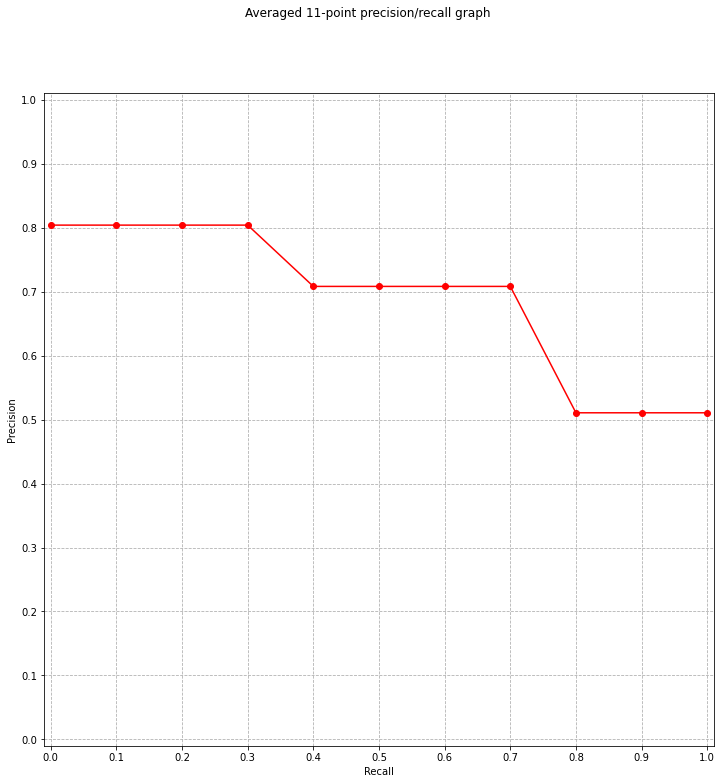

In [4]:
eleven_test = eleven_points_interpolated_avg(test_results, test_relevance, plot=True)
assert all(eleven_test[k] >= eleven_test[k+1] for k in range(len(eleven_test)-1))

## 1.3. [10] Normalized Discounted Cumulative Gain

NDCG metric is designed for situations of non-binary notions of relevance. It is evaluated over some number $k$ of top search results (in our case we will evaluate over the whole dataset, since it is small). 

For a set of queries $Q$, let $R(j,d)$ be the relevance score assessors gave to document $d$ for query $j$. Then,

![](https://i.imgur.com/LLogCYa.png)

where $Z_{kj}$ is a normalization factor calculated to make it so that a perfect ranking’s NDCG at $k$ for query $j$ is 1. In other words, we divide calculated DCG score by ideal DCG score. 

Implement this metric in `NDCG` function.

In [ ]:
import math 

def NDCG(search_results, relevance):
    # TODO: compute NDCG score for search results. Here relevance is not considered as binary - the bigger
    # the judgement score is, the more relevant is the document to a query. Because in our cranfield dataset relevance
    # judgements are presented in a different way (1 is most relevant, 4 is least), we will need to do smth with it. 
    # The simplest is to invert it, replacing each score with (5-score). For example, if the score was 2, it becomes 5-2=3.
    # To find normalization factor for each query, think in this direction - for this particular query what would be an
    # ideal DCG score? What documents should have (ideally) been returned by the search engine to maximize the DCG score?
    # When you find it, just normalize the real DCG score by ideal DCG score, that's it.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]       
    
    return 0

### 1.3.1. Tests

In [ ]:
ndcg_test = NDCG(test_results, test_relevance)
print("ndcg_test", ndcg_test)
assert np.isclose(ndcg_test, 0.640, atol=1e-03)
assert NDCG(test_results[:5], test_relevance) < NDCG(test_results[5:10], test_relevance)

## 1.4. [15] pFound ## 
**pFound** -- ranking metric invented in [Yandex](http://romip.ru/romip2009/15_yandex.pdf). This metric models user behaviour when looking at the search engine representation page (SERP). Metric assumes a user is inspecting a list from the top to the bottom. There are 2 global parameters, controlling behaviour:
- `pBreak` -- how probable, that the user will become tired and just quit at this position (`0.15` by default).
- `pRel` -- how probable the user will click the document if this document is relevant (`0.4` by default for a relevan document, `0` is given to irrelevant).

Then, to compute pFound for the exact page we do:

$pLook_i = pLook_{i-1}*(1 - pBreak)*(1 - pRel_{i-1})$

$pFound = \sum_{i=1}^{N}pLook_i*pRel_i$

Implement `pFound` below.

In [ ]:
import math 

def pFound(search_results, relevance):
    # TODO: calculate pFound score for search results, treating relevance judgments as binary - either relevant or not
    
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    # return average value for search results 
    
    return 0

### 1.4.1. Tests

In [ ]:
pFound_test = pFound(test_results, test_relevance)
print("pFound", pFound_test)
assert np.isclose(pFound_test, 0.582, atol=1e-03)
assert pFound(test_results[:5], test_relevance) > pFound(test_results[5:10], test_relevance)

# 2. [M] Evaluation of real search

Now we want to apply these metrics to some simple but real search engine. Print out all metrics you've just implemented for your search engine.

Please note that the data is the same, and metrics evaluate same search engine, so their results should not vary much.

## 2.0. Data

There is a number of ways to evaluate a search engine, however, all of them require so called relevance judgements - human assigned scores of relevance between `(query, doc_id)` pairs. We will use Cranfield relevance judgements collection, download it from [GDrive](https://drive.google.com/drive/folders/1u6dSUqdrXsckSHmVHNNE27eDiajMWLl2?usp=sharing) or [GitHub](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/cranfield_data). 

This was the pioneering test collection in allowing precise quantitative measures of information retrieval effectiveness, but is nowadays too small for anything but the most elementary pilot experiments (which is exactly what we are doing here). Collected in the United Kingdom starting in the late 1950s, it contains 1400 abstracts of aerodynamics journal articles, a set of 225 queries, and exhaustive relevance judgments of all (query, document) pairs.

![image.png](data:image/png;base64,%20iVBORw0KGgoAAAANSUhEUgAAA70AAAFXCAYAAABunSlhAAAgAElEQVR4Aey9z2vsTnb/rf2Y+Vtmq1W8zB/ysRbx7ru7s/H1YhYJTxpseLx4DLMMDnj3uWkMAYMhYb5JhnhlLmkz5BcY7MAsMoFJGMJ5OPVDOjqqkqolVbe6/b7g22pV1TmnXlXq0ltVkgrCPxAAARAAARAAARAAARAAARAAARA4UgLFkdYL1QIBEAABEAABEAABEAABEAABEAABqkXvH/3xrwl/YIA+gD6APoA+sOQ+kHvcXnLdERuOTfQB9AH0AfQB9IH0PiDPGVqiVyZgGwRAAARAAASWRIAH+tz/duEjdx1gHwRAAARAAAQ+OwE9nkP0fvYegfqDAAiAwIEQ0ANYjrB34SNH3LAJAiAAAiAAAiDQENDjOURvwwZbIAACIAACCyagB7Acoe7CR464YRMEQAAEQAAEQKAhoMdziN6GDbZAAARAAAQWTEAPYDlC3YWPHHHDJgiAAAiAAAiAQENAj+cQvQ0bbIEACIAACCyYgB7AcoS6Cx854oZNEAABEAABEACBhoAezyF6GzbYAgEQAAEQWDABPYDlCDXZx2ZNVVlQUa1zhAGbIAACIAACIAACEwjo8RyidwJMFAUBEAABENgdAT2A5fCc6mOzKqlcbXKEAJsgAAIgAAIgAAITCejxvF/04kr2RNwoDgIgAAIgMBcBPYDNZVfaSfUB0SupYRsEQAAEQAAElkVAj+e9oheD+rIaD9GAAAiAwGcmoAewHCxSfWB8zEEfNkEABEAABEBgHgJ6PIfonYcrrIAACIAACGQmoAewHO5SfUD05qAPm5+GwL+/0Q9//Gvi483//eJX+Wv/N3/2a/qjP3mjf83vCh5AAAT2TECP5xC9e24QuAcBEAABEEgjoAewtFLb5UrysV5RWZS0xi2928FFbhBgAr/6Df3RH7/QX/y7wOFE8C6Er/CKTRAAgSMmoMdziN4jbuymar+nv/iT5moqdwL+O9bB5V//8oX+6M9+21QfWyAAAkdBQA9gOSqV6gMzvTnow+bxE/gt/SJy/mHG7noW1p63tM5TWCzX6UxKn9v8hv6mBsh+Xugv/pIFNp/z2DQz09s6P+izQWRiqmejlVCvfWEDBEBgiQT0eB4XvbiSvcT2GxmT/VH/4S9/35Q3V1p/Ta19TepBb0H0HnTzIXgQiBLQA1g044SEVB8QvRMgo+jnJWBmdCPisZU2LHq1gG2LZiuuvdj1wHUZ/b1lw8QjhbS3gk8QAIFDIKDH87joJSIM6ofQpCkxBkQvFzPCV/6g91/xJLf8iDsR/9krsEMDE6fzAOcHIH/FVfrSA6BM8/l9Pb0/ac+X1+UaUY+rtZ4fPkHgcAnoASxHTVJ9YHzMQR82j55A57xD1Hgb0dvK62242V2zbNqeI7RmiomoJXKHbLhzHm3De8MnCIDAsgno8Ryid9ntNVN0Vgx2Z3XloOAEo1j2Y4WiF8U2b2Pjt/QLs8zIi1ARamsJkhei3o7/7kWzWz4kliy1BiXS6b68F7pqEPP5RT2sWPf+RZzYBAEQOCgCegDLEXyqDyN6q3WOEGATBI6XQFBouuq20gbOLZwg5eO1/efPDeT5TYOzdX4xaINIXuxvzn8ae9gCARBYLgE9nkP0LretZozMDh7dH2wxKJgffy0MOd0NINGrswMDk7vnRl4pNWJailJpuzXoeQQijoA9M2MtRHPHvhvYZAzeMj5BAAQOh4AewHJEnuwD77HPgR82j56AOO9QdTVjdz2WD5xbBM9ZpMGwn67o1ec90obcDtuTObANAiCwLAJ6PB8WvbiSvawWHBVNguiVwrP2IQad1uxtnaF+kERLULbyChuuWEeUSt9OoHJHbf/5q7dde4Oil/0Ku13xL+uDbRAAgaUS0ANYjjh34SNH3LAJAodCwJwD+AvqPmhzHtCsAOPdXYEqXzcUO6/xBsMitWXTXURPOycInHt4V/gEARBYJAE9nveKXsKV7EU24vZBRQaHjtjUVzx50NjHTK+OQ9Y4MPC0RLZbDi1nkmVxCg+ErSz4AgIgsEgCegDLEeQufOSIGzZB4JAIWOGrL27rZ3jY8ZqPSfNAKjXWd5/eLEVxeKxvi14mZs8prA8Xj59tdkK8ToueVxwSecQKAp+HgB7P+0Xv5+Fy5DUNiF4389lc4XQ//OJHvb3UyA4gTX5/T2/a1Vg5E9w70zt45TVR9PpBq9OygfKdPNgBAiCwRAJ6AMsR4y585IgbNkHgKAg4oSnPGY6iXqgECIDAzgno8Ryid+dNsA+HTtC2lgz75cIyHnlVVV4xdXnEEuH2i+Vlud/Q37SuxnZFZr/oZV+BeGsR27Wnlzd3ljLjaq1sZGyDwMES0ANYjoqk+Hh7e8vhGjZBAARAAARAAARmIqDHc4jemcDCDAiAAAiAQF4CegDL4S3FB0RvDvKwCQIgAAIgAALzEdDjeVT0YlCfDzosgQAIgAAITCegB7DpFrsWUnxgfOxywx4QAAEQAAEQWBIBPZ5D9C6pdRALCIAACIBAlIAewKIZJySk+IDonQAYRUEABEAABEBgBwT0eA7RuwPocAECIAACIDCdgB7AplvsWkjxAdHb5YY9IAACIAACILAkAno8h+hdUusgFhAAARAAgSgBPYBFM05ISPEB0TsBMIqCAAiAAAiAwA4I6PEconcH0OECBEAABEBgOgE9gE232LWQ4gOit8st+57XR7o8+ULVT39Otw/ZvWVzsNkQrVdEZUlUVNncwDAIgAAIfHoCejyH6P30XQIAQAAEQOAwCOgBLEfUKT6mid4Xuj35QpfX70QPd3R2ckXfXnPU5BhtWnZ5Re+O2mdNVK6OsY1QJxAAARBYBgE9nkP0LqNdEAUIgAAIgMAAAT2ADWQflZziYw7Ra4SbEb139Dwq0s9YaHeiN3v7QPR+xg6MOoMACOyQgB7PIXp3CB+uQAAEQAAExhPQA9h4S/GSKT6mid53+nbqZnfNkl0lel8f6fbULuM9O72jb9d3Zknv2ckX+vozt//8xVTg+dx9l7PFry91eV4KfHl6R89+JlksET47f6G36ytn+4p+3FhByWXq2WeZ/0TFGUBYx3P+SN/OnW2ug/HP9Y7H/+MvbT3Zv4/h0uc/faQ348/Nwp5e1UudDSNfP84zsv7NbPtA+7CPzYrKoqCirGgT4JC0C6I3CRMygQAIgMBYAno8h+gdSxLlQAAEQAAEdkpAD2A5nKf4mC56vYBkgeoFHQs2e9+qWfrMlWMBd/KlEaFExMKSBWv9Ty6RduVvH95d8js9X1/RmRKstTh1+1n8XrLNBys8a//enypf+w5smPhYhLsY2Lb03xe/zcsXBKxAPjNs5Oxul0dTpuE3uv6mPuw70j6+vhC9ngQ+QQAEQGCxBPR4DtG72KZCYCAAAiAAApKAHsBk2lzbKT6mid54pEbASRFMZGZj65lXL0IjopfL+5lS/Snvg7XC1Au7djytNC3C21mD3/pELRfoS7cCluNyotfUsyt6pSgnkXeO+gcrlWMnZnpzUIVNEAABEKgJ6PEcordGgw0QAAEQAIElE9ADWI5YU3zsUvTqh131icaWYO2B07Eh8wqhm2pPFu/YljPRmUVvarydGGUFdrUN0bsr0vADAiDwSQno8Ryi95N2BFQbBEAABA6NgB7AcsSf4iOX6E1e3uxng1/f6fmclw/Le4Tt8md7D+w7vT3cmftfOzO9crZYgbTi0d43255VVRkDXzuCMiR6I/GnzvSa5dLuPl6uH89qm/o5wW7uVzaxjat/oFrtXX55c5Hpnt51RUVRULkafcdwO158AwEQAIFPSECP5xC9n7AToMogAAIgcIgE9ACWow4pPrKJXq6QeJAVi7nLUyFqTYWbB1XxQ5ye6wddueXKqvwZP/SJH1rFZZ1A1EufW/cIuxj4nbjyXlzjeuA/Frzetrkf14lQ3tfYCsf/w0/+VJS9qx/GdXn9aO5r/uEnv6D/49/Ty/v8Q65Orqi5h7fLb1T9B+o55UFW64qoKNRf2Xa4rgoqiorW7d34BgIgAAIgsAUBPZ5D9G4BD1lBAARAAAT2R0APYDkiSfGRVfTqSqmZUp2c5btY4pzFPoz2ENhQhVneHj5IAgEQAIE0Ano8h+hN44ZcIAACIAACeyagB7Ac4aT4OHbRa5c3hx90lYM5bAoCZuk0ZnkFEWyCAAiAwCgCejyH6B2FEYVAAARAAAR2TUAPYDn8p/jYjei1Ty32y4X5U96XO3/d2/7s64Lm9wKLIAACIAACILALAno8h+jdBXX4AAEQAAEQmExAD2CTDQYMpPjYjegNBIddIAACIAACIAACSQT0eA7Rm4QNmUAABEAABPZNQA9gOeJJ8QHRm4M8bIIACIAACIDAfAT0eA7ROx9bWAIBEAABEMhIQA9gOVyl+IDozUEeNkEABEAABEBgPgJ6PIfonY8tLIEACIAACGQkoAewHK5SfED05iAPmyAAAiAAAiAwHwE9nkP0zscWlkAABEAABDIS0ANYDlcpPiB6c5CHTRAAARAAARCYj4AezyF652MLSyAAAiAAAhkJ6AEsh6sUHxC9OcjDJgiAAAiAAAjMR0CP5xC987GFJRAAARAAgYwE9ACWw1WKD4jeHORhEwRAAARAAATmI6DHc4je+djCEgiAAAiAQEYCegDL4SrFB0RvDvKwCQIgAAIgAALzEdDjOUTvfGxhCQRAAARAICMBPYDlcJXiA6I3B/mpNje0uimo+FpQcb+eaixv+Y8VlRcFlU+bcX6i5QWDnByi/sdVJ73UjuqXHtDh5HRtxsdH9X0PYe/bf6DKm6fS/l5clLT6CGTYapfom0v//dmqXoedWY/nEL2H3Z6IHgRAAAQ+DQE9gOWoeIqPaaL3hW5PvtDl9TvRwx2dnVzRt9ccNcllM3f8a6q8IPxeUbHlCen6frroncNGL/2pojGhfNY6DPjP6tuB3YWP3jbcY+L4uttjay+i1/Dat/9Ao434jQlYqXeNb5vaxMFvLImBHs8PV/S+PtKlP3Ho6SJv11dU/fTnizqx2GyI1iuisiQqqp7gkQQCIAACIFAT0ANYnTDjRoqPOUTv7QM50XtHzzPGn9+UFb354hcnxuaEtKJt5m3nOOEyNm5WNHIeNn8TJHiYg0OCm2CWXfDbZ/2Cld7hzvF8xbG1w3gbV/v230RSb0H01ijm2hjfP+eKoLGjx/OFit6EK8mJotdUvXM1PcF+wyzf1pqoXOUzD8sgAAIgcEwE9ACWo24pPqaJ3nf6dupmd804pkTv6yPdnn6xF2tP7+jb9Z27cPuFvv7M7T9/MVV/Pnff5Wzx60tdni/4Xp7e0bOfSXbjprkQfP5C8qLwjxs7LrYuEsv8Jz7Ogfg5ss2KyqKgoqxGCEdeJuiWG5oZRS967QmzWb584feJJYVuRtiKoRWt7t3SxZuK1mLpIi9p5KXFxs7Xgsp7KW6FD14e7P+2Wa74sabKL7P25WsBLeLVy4/55Nvn58+LkkpvJ6W8OhhiorC3/m4G18Rxv6bu8s+e+I3/Pn4izc/eS391m6qKRL5uXz/pP95/qLf9IsHw7oH2+ycS7Fx/MnVwbV0vr+31L+og+0py/7TlyxtxDNxU7aW9yn+pjp8eAjbpY90ce+74ao6/Kf5F3fv6z1D8H6vW8cks0laTSP/x/jP0+6P7l+Rb94f79u9X3TcG4XOGTYu/OZY9L07uaZ8k/4qvsV//PglGof4pj3f1+/Ln74nHR2/9updH9Xi+aNE725XkiOidzX5SRwxkgugNQMEuEAABEAgT0ANYONe0vSk+poteLyBZoD7Smw9ZX8xlAXvypbVSiYXumRO9ppgc31z524d3Z/Gdnq+v6KwWrHZ3I5ZtHCx+L9nmgxXYZum1s2D8tcqz6I3E78pMF73+pJIFpBCltQh2J0gmzZ5o+SWb5sStPsnbkD0J7Z4M2VCtHX1vrSkj/fp6DX7KuDgz+y+pCNgKxWVEpold2mnXz4cQKu/T+HMo3ebtqb8RY7YdjFBWwqrPvkkL1NkLQ8nb5N1S8I6u32D/kdzZS7z9LL/2/ynt1+HWmmlM8x/l2w4n8M2Jkvr4IHthw393oqT67tc4bGjN970mt4+zz4LGeHfHX11+on93YSHaf4bid+l1eRZwfAHM1z9ArLVrsP+44662p35/huLzxy2Xd21g+5T/PWxFE/jS9J/6QkOrfw21j4g/6L+x37Rv9/dtqH+a9MjvS+rxEa5fF4kezxcqevuuJHOavbrtr1Z3qimulNsr3Tzoy/um+ux3rIV3TLqS7UxC9IbZYi8IgAAIBAjoASyQZfKuFB/TRG88RBafZ1IEE5nZWDl+9YleP3PL457+Mxd5neuukG1iaqVpEd5k29OWPWmrnuyDoMzJ6hPf99ucFOqTJnPSKATY5vuqmUF1sxH1SbCr1dBJW1/ljUjwsxw8o3a/as00+7I6Tt7fnOC6k0sjNF2d1cOHQuW9bf6MpSfXXzCVdv12zH7tWzD3Zeo0b1uLEJlxYDvmv79+Cf3HP9yI27Cn/ULhpbRfJ+6WKCErMgf6j7ER4RuKq9ln69/u701fM/F73+rTX1RqbAW2TF2aY9HmkP13un9T90j/GYrfpGtuin+gVmJXQv9RzxSQPofiY0dD/UME0900x5N+KBfH7PYNts+w/5Tft6H+2WpDVYve+g/VT9nir3o8X7DoHbiSTESdwZ9rqAfpwJVyooQr1QF4rV0QvS0c+AICIAACuQnoASyHvxQfuxS9+mFXnXFPzPS2BGsPnI4NmVeMoan2ZPG82+4EnU/IefmvX6YsTmT1SZM86fQzjVX91GRrry0C3ImfsLltnTYfa1o/VVTduxj9SbowpOPkJBOrydsIESIpGhoDofJNauDklRP5pJef3ptSfzWzK23zdp9/kxbjJ4SuyRdgo32Fvgf9D9ZvuP+wr5T2C8WU0n6duAOia8h/L99QYPW+ftE5pT2Mix5RZY+xGfz39J+h+IPcAvxrXJ2N4f5jfIhjR/7+DMXH7nR5c8x60dqJR+0IikKRZ7B90vxP7Z+dOooQO2myfYbqJ+z4TT2eL1T0+nD7P0MDd+hKuT5p6Le6w1TM9O4QNlyBAAgcOgE9gOWoT4qPXKI35aKtGff8bPDrOz2fi5VMTrDy8me7ZPqd3h7uzEMfOzO9com0AmnF7lXSwyJVUfvVXxQuxtzTG7RY7zQnkXyv4NOmuedUnGTqkyZ50mlPIP09jLx0swq+OsjYqEVbWBjXAbU2vED1y0NZyLZnon12HSfvTxFNfeV9Gn+G7G9Vf8FU2vXbQfsucYifSXcXLfQFB29/6DPo353U23sgw+3b33/S2y8UX0r7tdh8uOXTtahJ89+y4e4VTuNo7ZuVEe4+9w0z868xcoKSX/nll69yOl9cSprpdRdoZHnb1n72dx7/1qa9oNSq91D8dV3d8cn3t/J98zX/UKu29/X3n+5xZ/L735Kh+ELHrRR97VAC3xzfuv04C/9+le71aDpdLz/vxt8W3bZ8s/w9/Ps21D9NeuT3pVU2cnw0/UvXr4tEj+dHJ3pbJwS+/uJKuN+1iE+I3kU0A4IAARA4DAJ6AMsRdYqPbKKXKzR4e07zoKozvre2ftCVWx2lyp+d2vt1jQh29+zqpc+te4RdDPx2BH0vcDJvL3pHPchqwIs8CXQnkf6E3Jww+WWZ8kEpvO9mRfwwIXOPrZsp5mXS9UOnWidh4mFULM5aD7vqi8+dVPoYjF8vsl05d+JtHgAj8p39tXiQ1U1Vx1VyjPK+w0h5wyCSVouaofrHyks2kTy+DWwtB/j5k/9tZ3kjvpPrx8GxDS9yVP/xs+qtttEPeoo1v4ytr/1YGNYPKKvMhRfj76Kiv/KiUfSLIuhf2Ejtn565mekX/f6iJCliSD3oyS7x9iI4Vnmx3whJ9xA5vjjlH4Q1p39vK9R/BuJvLX9ntnxRyvFu92FRJ7nZ03+Gfn+M1O6Jr1WehbKvJ8cXqquMy28r/ly31u+XSq/bxwtu3/cC/if3T3mMeD/8KX9feo4P82QGFX+nfp6D+9Tj+dGJXv8gjvpBHq8v5h5geU+UYjLuqx/Up1zJ7hO964qKoqBy1VwxHhcoSoEACIDAcRDQA1iOWqX4yCp6daX2cdFWLHHW4eA7CEwm4E7mW7N0k43CwKchgP7zaZp6akX1eH6Yojdytdov33p7eKTLwCsf+Oq2zzMV5JSnU64roqJQf2U7onVVUFH4JSHtNHwDARAAgc9IQA9gORik+Dh20WuXN/vnauSgDJufmYCZ0UqdufrMoFD3IAH0nyAW7AwQ0OP5YYreQMWOa9eGKszyHleTojYgAAKTCegBbLLBgIEUH7sRvc17c/1y5Nku2gbqTdT2p58iHSyCnSCQTEAt/fb3OSaXR8bPTQD953O3/7ja6/Econccx7ylzNJpzPLmhQzrIAACh0ZAD2A54k/xsRvRm6N2sAkCIAACIAACn4OAHs8hej9Hu6OWIAACIHDwBPQAlqNCKT4genOQh00QAAEQAAEQmI+AHs8heudjC0sgAAIgAAIZCegBLIerXfjIETdsggAIgAAIgAAINAT0eA7R27DBFgiAAAiAwIIJ6AEsR6i78JEjbtgEARAAARAAARBoCOjxHKK3YYMtEAABEACBBRPQA1iOUHfhI0fcsAkCIAACIAACINAQ0OM5RG/DBlsgAAIgAAILJqAHsByh7sJHjrhhEwRAAARAAARAoCGgx3OI3oYNtkAABEAABBZMQA9gOULdhY8cccMmCIAACIAACIBAQ0CP5xC9DRtsgQAIgAAILJiAHsByhLoLHznihk0QAAEQAAEQAIGGgB7PIXobNtgCARAAARBYMAE9gOUINcXHuiqoKPEu9Rz8YRMEQAAEQAAE5iCgx3OI3jmowgYIgAAIgEB2AnoAy+Ew1QcL32qdIwLYBAEQAAEQAAEQmEpAj+cQvS2i7/Tt9AtVP/05nZ2/tFI+xZePFZUXBRVfC6q+L7PG63sbX3GBWZZlthCiAoF8BPQAlsNTqo/NqoTozdEAsAkCIAACIAACMxDQ4/lCRe8L3Z58ocvrd6KHOzo7uaJvrzPUXph4Pv8SFbZ9acLEhM389esPbk3VRUHl04boe0XFRUmrD1/Cpi1V9HKUm6eSjlv09rWPbyd8gsDnI6AHsBwEUn1A9OagD5sgAAIgAAIgMA8BPZ4vWvTePpATvXf0PE/9aytG2J4+0lu9p9nYlejNWb+mNqEtIWyN6JWzpiItVHQB+z6L6DUXHjrts4AGQAggsCcCegDLEUaqD4jeHPRhEwRAAARAAATmIaDH84WKXl5m7GZ3Xx/p8qQtet+ur+jyxC5D5qXIl+devHaXJ7OANcuV69liO8vK++SfXM5sRe8jfTu/smVP7+hZzjS/vtRp3n+dbuJtlkhzrG3/3JD99Utq6s2KysI+TGWTVEBm2tDqxs3umiXNXdFb3pT1UufipmpmgsUS6OJ+bWddvxbt2eKPNVU3bhny14LKm4rWbia5Xp58v6LVfWmWUrfsmzA3TRrbVvYb0cv1cOn3aztr7fO7MqVPv1mR58Tl/TJutl3eN2lp8UmWYpsFaoJ/USKy2dc+kSLYDQKfgIAewHJUOdmH+w3Gfb05WgE2QQAEQAAEQGAaAT2eL1j0eqH7QreRGVmLwgpdsxTasenM1AaWSJs8EbsmrRbJ79S2Z0Uzi2Q7S+zSlTDnMlbs2noYoV7fJ8wxp9Yv0uCTRa8XuixQG9FHZGd65ZJnKzLlEmiiWhy6e2uNkGTh6URx9b2WmLRWy5FNWV5S7fI0Ipbr6oTszaoWynoJts+/ciKzZPHtMDWxNnY2rk7hJds2n1nq7Wz0xxdpj9H+Q/Y4plj7hPJjHwh8DgJ6AMtR61QfmOnNQR82QQAEQAAEQGAeAno8X6jo7a/s28MjXboHTvnZ2tlFby1QiViwnnmBbAS0F6w+TiuEzXJlt8sKZ53P51/yp7iftA7TCUgWte6fFYZemPm97n5bOdsptr3oNGWFrZaoNaK5LbCtEG/2GWHr7EqxylF4Qcwy2MwCGz/tJdub7yuqZ4ADdnrja6oa3ErxHyyInSAAAoME9AA2WGBEhlQfvaJ3XVFRFFSu/OW4EYGgCAiAAAiAAAiAwGgCejw/PNH7cGdmUG/5IVfmX6aZ3hGit1d4j26yXRfcQvRK4erCjIlhWYteURkUvbK0F7alFa6th3D5NBbjEdHrZocrfoiX+WfzSfHcG187lM43iN4OEuwAgdkI6AFsNsPCUKqPPtFr3uNbdC8KCjfYBAEQAAEQAAEQyEhAj+cHKXrPTu7c05zf6fn6ztzf2xGcfmb2lZcfX3WeAG1mYn0ec4+te1o0kVrOrGZ6KX15s7xPePY29cubi6pe2juPD7+8ubkPd+OFoniNUUcYeuf+nt96yfGGuDzfQ5s00+uXV9fl2TAL09I+bVrN5lqRXZJfTj0oOrkuF/4e5Q2tn2xsY0Sv9dXMQJtI66XcEdHtOXlRXi9jrhPSNjCTlMYJuY6KgB7AclQu1Uf8Pb0bqjDLm6NpYBMEQAAEQAAEkgno8fzwRC9ZEesfDnV7/Ui3nXfr8n3A7p5avnf22s4Os1hungIt8pxc1Q/D8vfiGvt83657EJX57kUyP8jq1D6givdfygdduZlo3i//ZhfAXvSWM4peL1j5Pb1Pq+ZhVBeNqDRLkcWS5frBTXLW90OU5bwsWJ2INSLVl+d7iYXP+jVEH2sjcmvb4mFTdfn6Pb1OpLNN945hU+6mquMvuS6cdlHSn79vaO0foMX1kvW8Xzf3Kpu4I/GZw02KWnf8uYsDff6bV0O58iNFL2aSkn/zkPGICOgBLEfVUnyY46+Uz0IQkZjfZszyCiLYBAEQAAEQAIGdE9Dj+QGK3p0zg0MQCBBgsd2e5Q1kyrQLM0mZwMLswgnoASxHuLvwkSNu2AQBEAABEMQ2/XUAACAASURBVAABEGgI6PEcordhgy0QSCfAS7bl7HZ6yek5MZM0nSEsHCQBPYDlqMQufOSIGzZBAARAAARAAAQaAno8h+ht2GDLEfjvP/ye/vHf/oH+8L9/MHvwvc0DHQUEQGA/BPQAliOKXfjIETdsggAIgAAIgAAINAT0eA7R27DBFhH91//8jv7un/+W/uN3H/T3//IrfFc80ElAAAT2R0APYDki2YWPHHHDJgiAAAiAAAiAQENAj+cQvQ0bbBHR3/7miXhml//97r//E98VD3QSEACB/RHQA1iOSHbhI0fcsAkCIAACIAACINAQ0OM5RG/DBlsgAAIgAAILJqAHsByh7sJHjrhhEwRAAARAAARAoCGgx3OI3oYNtkAABEAABBZMQA9gOULdhY8cccMmCIAACIAACIBAQ0CP5xC9DRtsgQAIgAAILJiAHsByhLoLHznihk0QAAEQAAEQAIGGgB7PIXobNtgCARAAARBYMAE9gOUIdRc+csQNmyAAAiAAAiAAAg0BPZ5D9DZssAUCIAACILBgAnoAyxFqso/NmqqyoKJa5wgDNkEABEAABEAABCYQ0OM5RO8EmCgKAiAAAiCwOwJ6AMvhOdXHZlVSudrkCAE2QQAEQAAEQAAEJhLQ4/lhid7XR7o8+ULVT39Otw8DJFzey+v3JmNS+Xf6dmp9sJ+z85emvNwK2Zfpi9xu6hat1yLjHhnU94qKrwVV30eWR7GRBDa0ui8Ne+Zf3q9JSoPNU5PG6SbPk8wx0q0v9rGm9VNF1U1JxX14Fm7zVFF54XxvHZ+u36pVPx/G6M+PteKn7Wv/bb6134+VreNFRWEKdc6D2dADWI7AU31A9OagD5sgAAIgAAIgMA8BPZ4vVPS+0O3JFzKC9eGOzk6u6NurB2DTRoleYyKxPBE9n385MtFrGfbWy2Pu/exrn96CMyWuqbooqGShxML2oqTVR8A0RG8ASu5dG1rdFFTcOKH2IdrKuTaiN5sQs/6Km5JKjiMkelv9wsUr8g3Ft74X9aNu+amEjf9aiGv7w3y9fxMnX1TYmrVos77jyzva4acewHK4TvUB0ZuDPmyCAAiAAAiAwDwE9Hi+aNFrhK0RvXf0XNc/XbTWRVob6eWni8OW48V8mV4vwbDTPruopj0pNzO45qT8eGaydkEvrw/RNs5RWyQSDYnKueIzfoWY9XaNfy/KeafqQ/3xCUHoDPbn917Hf7bjHeZrPLlZ3uqeLwpte3wIH4rN+FrMU1IPYPNYbVtJ9QHR2+aGbyAAAiAAAiCwJAJ6PF+o6OVluG521ywj7orey9Oreqnz2emdmAlulvCGlye7Wcpo+aa5wuJwyD4Rvb7Qt/MrswybY7g8f6Tneqaa0x/pViyh5jwm1pM7+kexBJuXIL9dWztytpv3+WXe3v4bhy3K3l6/1D7afPwM9mMdI6fb+CwbG4vkb5d7n534duhrn4Zf79ZmRWVRUFFWI5aG8myXm901J/fypN6esPtls+YzNhPcG2A8kUWIXxprlubeq+WnPLvJs4x+6e5NRevQTHTcRX+Ksm/8SBHHs49ieXGHwWD5fvfbpbr2EOLTiDjHJshvOwfR3NuJ3ma1wFB8bRGvZl6j0YxN0DO92k6XL+eoYxwlWvuOL+1/t9/1AJbDe5KPNf9+lbSecVV+jrrAJgiAAAiAAAh8VgJ6PF+w6PUCi8XbIxlRZ1rNCjMtAuV337hh0Tq1vLfuxaO+59fZZ8Fqsr7bZdJeMKp7gd8e7H3KZ606WtteCPMstxG6wfuLrQhv7l0O1E8tETdc6iXjLj5v++HOCPDGnqunj9/V6RsLZbOt26fh07s1WfR6ocsCU4lO6diI4kbQyKR5tq0oMUut2aCfYfvuz4Y3tOZ7WLeebYtFp0XWhtYscGsGTXottI3w8QyadBuhLh/zO2a/86UvOnA89YUAHc8YP+EyMdFrZnb9vd5u+TWL7/re76H4XBubiwlm+bBnG45j3F7Hpdd+D1/PfLToTTy+xlVudCk9gI021FMw1QdmensgIgkEQAAEQAAE9kxAj+cLFb19lKyok6KMyAo//XCmPtE7vnwTW9B+cLmvjZmXa5syAYEbEr3NzGrjk7eMUFYzxU19hvnouFlQS/8m3YtcJdLbkRzAtwyid/N9Ze8XlbOV7kFMepawFkZSVE3EZkS09833rt6vmpnkYH15NrARZr3lJ8bWFG8EWS0mm8T21ihh1jYR+hYVvUS0+e4eZHVRkl0C3PDp2FLxGbt8EYNn7/mhU/Ie5k7hiTui9mN83X4/s65inxjN3ovrASxHQKk+IHpz0IdNEAABEAABEJiHgB7PIXoN121Ec9MQWjyalB7Ry8J0K9HrZ18bl0RuJva2fip1eKa3EcG2sIxVbnOqFr1+mXQdrxfAMo5D2Q6KwAnBs4hgAVs/bdiKDD/TWwuiCS5Sim78E4rv3VJrP5OcWN9o+RTng3ligixS0AizHtEZKTa0u0/0yrKDbdaKzy4n9u3NdsyFDs9fGp5ru+XfeLRCmwW7fjK5af9maX190SVnfHPVM8GOHsASimydJdUHRO/WaFEABEAABEAABHZGQI/nByt6zSyou0/2zQtB9RojLe4sZb/819/HyjOndkmvfiJ0uHzTVuF0Z3+G5c165tp4dqLaPs36nZ6v78z9vY3I9fVrnnit66fj7ohe/+TqE3vvcGO7qfvkLb+8uRhzT+8W3qMi0AkzXma7hTn/0CP7tGheumxnDGsR5EWHePqun1VsC5SR/smKrqpePs2iSz6sqLnH0y+wJvOE4dI+7XqwvIcxNr4hwetmnev4vZ/uEnUrJseL4WHR65Z2t8TjUHw6XrYhn+bs+XkxvG38zn99D7iP0ffTIb6Nf7NlBLMvK9N8PUJpMl9ke11RURQ7f0+tHsAi0U3anerDiN5qq1+PSXGhMAiAAAiAAAiAQDoBPZ4fluhtPaipeRgU3897+yDex+tELN8TK//+v1+K9/xeR8pHyrKdWhRH8tTp/CCrU/Egq/pBUa6hxIOsOPbL0y/N8uKI7UYA82xx83CrW1kPMzNsRW/nQVaODwtez0Q+KIv3ySXOfrY3tsQ6vctFcnrRO+pBVhGbod1zi15yIsTda1k9rZqHVvklpR9iH+czS5D1u1THig4nav3yZmO/ar+yySyJbb8Ll5dAWxGcUN5wHBkfiywZm9+u7zm2Ir31ILCbVeDCg/PvmYbaNrgvUD+OQSzvlkvQy/re4saYfIcv16XsxNd+UJhJr0WqtzM2/i6f5v5n96Rpz1R+Cr42Auff5+nM9I5sX1e9dVVQUYwUzB7RiE89gI0wMVgk2cdmTVVZUAHhO8gUGUAABEAABEBg1wT0eH5YonfXtHbkLzTTOt61E71q1ntre4d+L6+vcFT0+gz4XCYBPeO5zCjjUR16/PGa8cqBag+zvByRHsD6ohybtgsfY2NDORAAARAAARAAgTQCejyH6E3jljFX+H7i8Q7nEb1mCfQh38vrAGa/33J8Q6FkHwF+0NTWs7x9Bnecdujx9+EyqzR2P8vLIekBrC/MsWm78DE2NpQDARAAARAAARBII6DHc4jeNG4z57LC1C8z5vf4Nq9kmuBKLP82y5Xr1xKl2mzH1VrunGpi7/nU8tYbtfR37/EhABAAgbEE9AA21k5fuV346POPNBAAARAAARAAgekE9HgO0TudKSyAAAiAAAjsgIAewHK4TPHx9jbLZcoc4cMmCIAACIAACIBAYHUYRC+6BQiAAAiAwEEQSBGkUyuS4gOidypllAcBEAABEACBvAT0eA7Rm5c3rIMACIAACMxEQA9gM5ltmUnxAdHbQoYvIAACIAACILA4Ano8h+hdXBMhIBAAARAAgRABPYCF8kzdl+IDoncqZZQHARAAARAAgbwE9HgO0ZuXN6yDAAiAAAjMREAPYDOZbZlJ8QHR20KGLyAAAiAAAiCwOAJ6PIfoXVwTISAQAAEQAIEQAT2AhfJM3ZfiA6J3KmWUBwEQAAEQAIG8BPR4DtGblzesgwAIgAAIzERAD2AzmW2ZSfEB0dtCtpsv4pV8tw+7cZnLy6oiKgr7V1ZEm1yOYBcEQAAEPjEBPZ5D9H7izoCqgwAIgMAhEdADWI7YU3xME732feiX1+9ED3d0tvX71HPU+lBsWnZ5RW/e9llXROWq4W2+V813bIEACIAACMxDQI/nhyV6M1zpfbu+ouqnP8eJxzz9K93Kx4rKi4LKp0O7xr2h1U1BxVf3d79Or7PMebD1d5XYd/z79i/bMrK9eapMH/d9ZXpfF31vbL+LxHoou/UAliPuFB9ziF4j3IzovaPnHBU5Spu7E727bJ+qPMrGQqVAAARAYK8E9Hi+UNHbd6U1w6C39dX2vvh20b5rqrxg/F5RcVHS6mMXfmf0sWfRsr4vqJgoHCbZ2HP9h1pysG6Z49+3/yE+g+mGz/jjsq/+fWmDcR14Bj2A5ahOio9povedvp1e0bdXIjIXcpXofX2k29Mv9mLs6R19u75zF2a/0Nefuf3nL6bqz+fuu5wtfn2py/MF3cvTO3pmX/xPXDg+O38hedH3x40d11oXgWX+ExWnMyk/6njOH+nbubugzHUw/rne8fh//KWtJ/v3MVz6/KeP9GYcubH39IouTwQjXz9Tx3H1tzGygYH24SybFZVFQUVZTV+avCbiJc74BwIgAAIgMC8BPZ4vWvSGr7QuR/SG45u3wcLWrOitvhOREb0VjZxvDJv/BHuNcLhZTTphOWbxMQefKd1o3/6nxG7KTjwu++p/zP1uiLsewIbyj0lP8TFd9HoByQLNC7pGlJqlzxw8C9iTL62VSCwsWbDW/+RFWydSbx/eXfI7PV9f0ZkSrLU4dftZ/F6yzQcrPGv/RGT8qfK178CGzX9F31wMbFv674vf5uULAlYgnxk2cszv8mjKNPxG19/Uh31H2sfXdy7RuyEqS9zT67HiEwRAAATmJKDH84WK3r4rrXbQuxy40uuvMpsr3eePzZVupimupJv0Ux6Uryj9SndffInNNWnQ5GWObhbJzCgp0fuxpkoswS1vKlr7mWA+GXdLc3m55eaprL+f/d8v9XLM6knYuKnaM8l99t0MoPFxv27s17PRYokmxyFnW0VspvxFSaWvhxSoPf6NIDB2V7S6d3VrxW8vGHgG9aeIg5nw0mufVt6HxfE48dFTfyLqj78du26/esa/h4/pnSrd1LPm2/bhGTTt1B+/tb9q9b/axoXtp/185/C/btr+a0Hcfr7/9/NNPHY/4vaJIvHXfId8RMqL/mn7Xbt/+/qF2rd1/A+550msof6v+k/L/uDxnxBATxY9gPVkHZ2U4mOa6I2HZgScFMFEZjZW3vc7JBr9TKn+NBdpnes+IdtKcyJaiuB49DalLz7O0ZfeCGQneo2474redjxNXi6v6+2/p9Z/qH5zpW94hheCdy6csAMCIAACHQJ6PF+w6I1daR240ksunZdumeq/t69U60FcX0lPutLNg2wsvg7z8I7JotcLXRanQpS5k87qu79XdkNrFrZOcJhg/Inp/dqKrFqQcqo76Rb7NmbWSorsgnrtS/EmhY44cTeeAkuMjQg3vp24MnWzMZmZ7YT6GVHANhwDa9Pzss1h8khudnfgfxtH6H5MKz7Gz7HHyvfHL7kE6jLIR5ff0JovDigWKXyC8Tv/ntfmu713W9tvQIf5jvbv+y9fcDFOuH5Fq//b7/39o4lPb7njo8e+KZF7prc+Pl39/LE12P66PkPfVfsk2jeM+eJTz/E/5DmUrgewUJ6p+1J87FL06odd9YnGlmDtAdGxIfOKMTLVnizesS1nojOL3tR4OzHKCuxge7OyS5r9KL0Dl3ABAiAAAp+OgB7PFyp6+9rFzfTyky/rf82VXnuC4AWpz9BcKQ5dSQ+eVPjlXOIEwFtb8qcReG4mt55hc9+NaPTBf28estPa70SDFy02uxNKcuY24EPa0ULDu5WfJo8/WXcJjUBtfHohzvZT6texK0W782PyKKHnYzNCzc8wu3q2edicHT/eQOJnrHxnv45ffq9FiHWaxEfM7hc3ZWsm1Ifex6eVR7VfqJzel8JXl/E+5afJo/yHl/uLiyb+gowsJ3lKB6Ftk7d9AUX2z7pIMF+dOrjRV39db9Pmri+ntP+Q8772SbVvYpQX2oacJqbrASyx2FbZUnzkEr3+ntt6JlNflPWi0c8Gv/JFXbtSqblH2C5/9hd93x7uzP2vnZlOuURaEbLi0d43W8ei8sS+dgRlSPRG4k+d6TXLpd19vFw/ns019XPjtblf2QT4TmPqH6tbvd9ftC62v6eXn9Zciac3s83Og6zWFRVFQeUKsrhmjg0QAAEQ2JKAHs8/lejlwdsMyH7A9fDUoCxPPOzgr0W0L7i8z9STTXny2hZ0ViC097llt/XMsD7p73LQJ+bdHI1NmWbiMifLYdGbUr+O74CoMXlCopfzfi2oqp8qrWa6RLAdPyItZTNWvrO/E3/Dxszii3qYsgliY/OxpvVTRdW9W8qtyhg7wm6oPp04vaBU5Vq2Evm2yoSce19SvHI+w0r3z3af7sTd4RtxmGjflA7G0WNXJfXVX8dvjhnH3KSptlSm+78OtE+qfR1jv9P0VD2ApZdMz5niI5vo5TAjt980D1pqHtR0xiuO6gdduXFKlT/jW4H8yicnEP2SX//ZukfYxcAPipL34qYQ5PGytsnjrBOhvK+xFY7/h5/8qSh7Vz+M6/L60dzX/MNPfkH/xz286pb3+YdcnVxRcw9vl9+o+g9V1oveEQ+yqtz7ef17es2nenrzuiqoKPTv2FBQSAcBEAABEJAE9Hh+sKI3eqV3aHlzfVXYzRS/vpgnSsp7phiYFbvjrnRL4NFtP2iOuFIctckJbuaP78H0yzt5eTLfo1rPxLoTWxa2Xvw2Itct36yXTxKZ5c0sBPnBWSn2Y4JEBR46MR4SvSn+O3YDosbkqcWZELZOrNinYfPScMuu4dNUouOnSUraipXv7A/Eb8RdaBZ6sH38rGczg8Cv1vHLUH3gUT4+Q6yNnX/Pq7O8OZHvaP+py5ulWA7xFfVsb7rjQxxfJlYtNF09xy5+76u/SRPxS9Gbcny066O+DbXPYP+y9nSMysvor3oAG22op2CKj6yiV8emL8rq9BzfD2yFUw4E+7O5oQqzvPvDD88gAAJHQ0CP54clesVV4/4rvSxkmwdatF7ZwA8GeXik5lUIzSsh+Gp0vQTML5Pyy5zn7gJe9I64UjwYyod6kJBZwmpFsDkZFWLJi16zFNqcSDtRpB9kVd8jbIWvfFCWXSLrRDafNAeWPjcPQnKzcYE8Z38tyt5U9cOQyqeVeUVT86CmtPqZ+0j9STr7awkT8aAufmBW/bAqd4+ryV9Sxb79UmfmE6ufvygw2Djx+vNFBdk+g/Hzw7ZadXLOe9rfL8VttVHrQV++AjE+/fGb0tK/fxiZuMBg7iGO8fXuWbx67q32SfG/Ng9683WUD1pK51sH0t3gB1ndNA+Ak/Zr0an7txCpXYOhPeH6t+LXtxt4xpI/xyGO/5Cn9r6B/s+Z++zHjo+t69+Oyn/TA5jfP+dnio9jF72HtsJpzvbfuy1zboBZ3r23AwIAARA4eAJ6PD8s0btL/J/2SrefCdwlbPg6ZgKtmchjrijqlp2AHsByOEzxsRvRa59F4ZcLty7K5qi4WyXl/dnXBWVxBKMgAAIgAAIgkJ2AHs8heiPIP++VbojeSJfA7lEEmvuPRxVHIRAQBPQAJpJm20zxsRvRO1uVYAgEQAAEQAAEPh0BPZ5D9La6QPvK+qe70i2XArvlp/be1hYkfAGBAQLuvle3xLdZOj5QDMkgMEBAD2AD2Uclp/iA6B2FFoVAAARAAARAYGcE9HgO0bsz9HAEAiAAAiAwhYAewKbYipVN8QHRG6OH/SAAAiAAAiCwDAJ6PIfoXUa7IAoQAAEQAIEBAnoAG8g+KjnFB0TvKLQoBAIgAAIgAAI7I6DHc4jenaGHIxAAARAAgSkE9AA2xVasbIoPiN4YPewHARAAARAAgWUQ0OM5RO8y2gVRgAAIgAAIDBDQA9hA9lHJKT4gekehRSEQAAEQAAEQ2BkBPZ5D9O4MPRyBAAiAAAhMIaAHsCm2YmVTfED0xuhhPwiAAAiAAAgsg4AezyF6l9EuiAIEQAAEQGCAgB7ABrKPSk7xAdE7Ci0KgQAIgAAIgMDOCOjxHKJ3Z+jhCARAAARAYAoBPYBNsRUrm+IDojdGb5/73TvB+VVp9+t9BrJQ3+Cz/4YRbbCAfrp5Kqk4qtdTLoSve/1n+bTZf5dLjUC8srT6Hiu0EL6x8AL79XgO0RuAhF0gAAIgAALLI6AHsBwRpviYJnrt++Avr9+JHu7o7OSKvr3mqEkum7njt+/5NieM3ysqLkra5n3x6/vponcOG7nop9jti78vLcX2HHn2HcO+/TPDJcRg2nLEMTZHH8htIyffQduHKHpNg9jf3rjobVptkEGTda9bejw/XtH7+kiXJ1/InFhshfydvp1+oeqnPzd/Z+cvW5VG5pkIHOyPxkxXwg62/q799x3/vv0nHAabp4rKi8Jeaf9a0PSrwqLvHelMlx7AEjBvnSXFxxyi9/aBnOi9o+eto9xnASt688UvTrzMCXlF28zbznEyZmzcrOiA5mlaHaIv/jn4tJyN+NIX3whzWxfZt38OeAntYMBB9B5k/9k66KQC4rd3IP9i+u9AnHo8X6joHb6S/Hz+hXoF6YDoHSxPRCl5wryH4w+Xm2vvtCvlc0Uxyc6eRcscB/QkG3uu/1DbDdYtc/z79j/EZzDd8NluBkva7Kt/X5q0cYjbegDLUYcUH9NEL19YdbO7ZpxSovf1kW7dhdez0zv6dn1nL8CefKGvP7MXZP3Yx2MUX6BtzRa/vtTlOe3y9I6e/UyyGxdNmfMXeru+qsv/uLHjVsuezH/i4xyInxtls6KyKKgoqxHCkS/euGPDHCde9NpxzS7H9PvEhR43I2z7/4pW927p5k1F64+mp/CSztbFpnspboUPXvbp/7a4iNRr3/0uGrv3awouL/1YU3XT+C5V/E1NQlvD8Q/xoUn+iXR5U9f6AsJAfD18/vxdtLVrD1OXzvLcTdP2vv3q1QJ9/hPs98TnVyP0tr9osrG/0332ax737f7vYzPuP1aqf5Vbrabo82/t9/TfBH7cf+pjly8G369ax6/uX7HjI8Z32/i36r8k+hD3veDvRl//FB1Ebwp21ZNgfFM1K2FEHvbNdTXx1/3fHp9xvvb4KG/Eb6S0L2KK8Y22D19c8cejO2ZL/ztX/z4M/X6IABI39Xi+aNHbdyXZCNLTR3pLrLjOllJ+qujti1/HM+9323HNEoURV8rnjeUwrZkDWh6II6oR/VEYYWtpRebgM6VO+/Y/JXZTduJx2Vf/Y+53egCb3A4BAyk+poteLyBZoIpxTF+sZQF78qUlajvjklwi7crfPry7mr3T8/UVndWC1e5mG1bc2jhY/F7yqqYHK7DlCinjr1WeRW8kfs9zsuj1opZP7oQoNSd1nOZOLk2aGO/8DFp9krcZmFGzdvQqi77jy1cx7bPHvjnxs/U0J+J8guxOWqvvfo55Q2s+cb3wPNK89sVv0mJ8JvuX7cKxMv+SCtmGvo3UPlkzE2OIjy8rxURrprLxX1/oaKVbL4N8ovZF+Uh8sh5c/9VNeBWPiUH6aRdM/Na1X7ev60NG+Pj+49q37u98gYNXG9X9IdFtnU35T+w/8fZ18bBgMz7c8aviTzk+0viq+Fu/KxzAuP7LJcP+rT8+Hvr6Z423s9Ftr02sfwf75wBfCtg3vz/dC/TB+g20v+2LbKvhsHE+7ZJquT/Ov4OlZ4cezxcqevuuJDdXo3nQ9n/+yjcRl+1bnjxUvqHXObnwSX1X0k2evvi9kYHPyScNoSvlzmfflVw+gPhgccst6ytFXws6+79f6ivk0StN7KLPvjsojI/glSjX6V0MrStlIjZT/qKklCtF8kpg/WMbvRLqDnrv33+KwcmcoMhlqa2ZgqZdgz8KTXJkq6f+/oeUYwrG346dBzbZfvXA1tc+gfYzrOsTlLYPk2bi8QsQ++M3lVZXmmsbbmDr5zuH//iV5OH+EWk2ubv3SnUk/pqvNBTajpQX/dP2u/aV/nqAZZND7R9yK/b1t890+8JVZ1MPYJ0MM+xI8TFN9MaDZPF5JkUwkZmNlTO5nXFJiF4/c+vHRflpLsI6110h28TUStMivMm2py3b/6unlR2L+GT9ie/7bUSh/t01v4Hi+Np8XzXjhvt9r0WAq5WxIcpsU9lk+yJmb7/1e+3HHveZcp+dt9MXfx+fOfwbke5j5xkjPVPnx7EevibGAB+un46f5Em/Ob/QJ+jcZ9r7tuHTsu8A98WX0v7BevjGG/gcst/HRx8LxpXkN+Cbk/v8p/afKD8TS3Ms23DcMf+d2uczvo9Fjo8OB1e3vvg5yxz919gJPVsgsX+6UAMflkX798qdc+lzgNDxM8CXnAAdsh+r31D7m3QTl4y5aV9j189Oc7tGfj8CYKK79Hi+YNHbfyXZDMzq5EDXunNyIDKMLp90JT3hSriIJbg5WfT6H47QlfKCeq+UeWF6v7YDTGvAsB20FlDmR1A8bMSV7bXvBy7u1O7A5IOhFActMwn9aNmDpudKUYJ/+4Nb0ip0JdQ1hsnTMyg3bWYP3vaPhE0Nxd+UG96Kle+P3/2YiNhbdRnko8vPfKXT+fe8zADEFxBEvG0yYb6tOrUL1N/C/Fz/jV1J9v2O+3xP/6iddDaG7ZsiwcGnYyy6o6/+Jq0+Zt2Vcn9sDbZ/1GUkQbXP7PbbbvUA1k6d51uKj12KXv2wq864JkSvSWvNyoaZdGzIbELoptqTxfNuu98nM3bIJXjNbLA+7s2Y4X9f+Lj7WlBVP1VV9V8XfN/x1Vu/bez7RMgHXwAAIABJREFUY1IYtMeuH7tFwpabffH38ZnL/+ZjTeuniqp710bqBLwvPq6qjlFWv5NmfkvlRf62wJVl/Xaf/177zkAnjzec2P6cPWrD2wp9Jtjv2BV8TJo/Frx9ke53RT8H/Bv7qq1Dtjox+kwmFt3/7ZjK5wyp9tlc0MdA/D6Mqf036t+Mj8P908fR/WxYyDRdV/29zjvAd6roHWqfFNHLsQ7xr+ujN75Xeg/p8XyhorcTd2eHGYz3IHpTr6R3Al7IDtPp3JWxeobNfW9dSf7ePGSntX/gSlCq/aGDg3GFDtyhgybFf8eu+SFo/xCZPHpwcG04dKXQN3XHj09I/IyV7+zX8cvvtQixTpP4JFxp6+Pjq9eJ07ep4qptpfDVZbxP+Rnyb6/ahwdV38875SRP6SC0bfL22zfFgvlCBsP7+uqv4zdt7pintH/YY7O3r33msN946m7pAaybY/qeFB+5RC8JwWlqElve7Me+13d6Pufly/IeYfu8C3vrzzu9PdyZhzp2Znp7HtJoxe7VyIdB8lmLu6e3GHNPb38b+j7GJ8F+W64I6uv//vi39zjy0mE7zvmLcN5z+/gKC2Oft/Xpjusk+wHR65c3m/vxjOEN8fJFvgfZ/z61/EW+9MXfy8eNF+P925Py5qI3z861Z+I55L746vQQH132w12UrS/y6YuObI3br2w9KLDPfyutY98C1wztXqLU/jVUx9qe3kjoX53YTBl3fsPbfNHHL5/nVUl8X2XNTztU34f8J/afToy1G91+Sugm2mdzQR9D8ddLbf3tBeP6b9S/s98cX5yz2z9rHJ0Nx0e0l1nebNq0yRysu0ke4Ovj4wsX7jkIIftsKuhjoH3M77W5KGJ/U+3vto3J/r757X7+TU3VFkRv/GFXY0Xz8q58q0Yf+Go6asKVuPpkovNUWdspgycJ9cywPunvBhU8YFS2UJ6hgyalfh27clBwMZg8SpyZJD9oDMwUcN6OH1W/oa+x8p39nfibHxSzVEfUw5RNaf+JV+pj9Tf+RTx1Pr8vkW/IjubZ4cQZDCvdP9t9ulOuw1d7Et8T7JvcwXzCzsBmX/11/OaYcXxNWkL7R91z3D0zZZPtRx3bhBRBOmBiMDnFRzbRy9GJB1nx8uTLUyFqTfTNg6r4QVfP9YOu3OooVf7s1N6va0Swu2dXLnvm7eb2IIfHiW99L/AgPJ/Bi95RD7LyRiKf8nh0J1leEJr+5y/qyttneN/Niv7J36PH3y9K4mXS9UOjWiJLPCiGb6OJ3MLSjdCJsJh9d/zoC8725M9Z07d/mCV+/h7HrsfwnnD8Q3zMqeYk//a3tFW/4INwwvGZ32fffvIz1jb8kC8W1Ya3+103Qs49wMfZ6LZfxL+BKdKU/b8abL+R7a9ES7hNeW+//Vb78m++FyGCT+uiJbeN55cUQ79/E3df/xnkZ2+P4YsUvg/J29NG26/rNhT/xP7LAUbq6H+j+PYiWT+uZ7d/mpoG/rPxdW4v9BcxIr7bvy9t/zVf0Vdav4v8Ozlkv+bL7Sd+U7nfud+vf5Kx3VT1727Jv8HuvvI/f0/lH0BjdjVi2efQ4/mRzPTa+3jlwze4wkagRq5mt0XvFuX9yQA/+dJQDV9J98BHf/qThrmvlPuOLZZ3dq4ku84pr6Q3Itd1ytiVphT7iYLQ/IC3Bjt3T0fflaIE/x27XF9RH24zk8cLMfkwCpPXPy0vPlNQ21Dxb9MfOnG6wp39gfjlD2/TdvYHyTy5NNr+7kfV/8jxMDviSn20/q59fExmAJbLmxP5RttHAO5wMmmu/4r6m3xCCHbKhfgKP+3NYfsmv6unvxO6bWP4W1/9dfxS9E6eSRpqn4Tjb7h28Rx6AIvnHJ+S4iOr6NWhi+XLOinbdz3jnM0RDIMACIAACKQR8OdnabmRi45neTORuNp9wleyxRMwI1ez5fKuaPlIWb4aXpfvu5I+Vy/zojfHlfLIlRi+RmJOmP3VUbl8jPcZAecOOv3IdCGSYld6zDUYPml29lufUhxG8pz9tSgbuVJklpUl1s/cR+pP0jkmIXzMvQ3+ceqtK/0DVwojsXNd6yt9Q30kYoPLy/YZjN9cPdOzmvErcfYamRNtso22uVLPdeuJ31Rdto9/GJm4wGCe9mnaY+RMzKD/yJVO1f/7+fY0orqSW19J5SKyv0nGsv/3mG6SxGyE6J+t/hGY6TJtLPlzDFvNJA30f1fHevZsa/tNDUNbKYI0VG6bfSk+jl30HvqKpm3aG3lBAARA4DAIQPRu2056PD/Ymd5tK478cxHAQTcXSdixBFozkYACAj0E9ADWk3V0UoqP3Yje7psG6guvo2vXV7DtTz9Fuq8k0kAABD4Hgf/+w+/pH//tH+gP//sHU2F8n5dHtBfpC+ZqdWK03CdP0OM5RO8n7xDbVx+id3tmKBEn0Nx/HM+DFBCwBPQAloNLio/diN4ctYNNEAABEBhH4L/+53f0d//8t/Qfv/ugv/+XXxG+z8tjXKugVB8BPZ5D9PbRQlqbAK40tXng20gC7SXU6Q9xGOkOxY6GgB7AclQsxQdEbw7ysAkCILBkAn/7myfimV3+97v//k/C93l5LLntDzU2PZ5D9B5qSyJuEAABEPhkBPQAlqP6u/CRI27YBAEQAAEQAAEQaAjo8Ryit2GDLRAAARAAgQUT0ANYjlB34SNH3LAJAiAAAiAAAiDQENDjOURvwwZbIAACIAACCyagB7Acoe7CR464YRMEQAAEQAAEQKAhoMdziN6GDbZAAARAAAQWTEAPYDlC3YWPHHHDJgiAAAiAAAiAQENAj+cQvQ0bbIEACIAACCyYgB7AcoS6Cx854oZNEAABEAABEACBhoAezyF6GzbYAgEQAAEQWDABPYDlCHUXPnLEDZsgAAIgAAIgAAINAT2eQ/Q2bLAFAiAAAiCwYAJ6AMsRaoqPdVVQUVa0zhEAbIIACIAACIAACEwmoMdziN7JSGEABEAABEBgFwT0AJbDZ6oPFr4VVG+OJoBNEAABEAABEJhMQI/nEL2TkcIACIAACIDALgjoASyHz1Qfm1UJ0ZujAWATBEAABEAABGYgoMdziN4ZoMIECIAACIBAfgJ6AMvhMdUHRG8O+rAJAiAAAiAAAvMQ0OM5RO88XGEFBEAABEAgMwE9gOVwl+oDojcHfdgEARAAARAAgXkI6PEconcerrACAiAAAiCQmYAewHK4S/axWVFZ4L7eHG0AmyAAAiAAAiAwlYAezyF6pxJFeRAAARAAgZ0Q0ANYDqepPjDTm4M+bIIACIAACIDAPAT0eA7ROw9XWAEBEAABEMhMQA9gOdyl+ugVveuKiqKgcrXJESJsggAIgAAIgAAIDBDQ4zlE7wAwJIMACIAACCyDgB7AckSV6qNP9Jr3+BZ4j2+O9oFNEAABEAABEEghoMdziN4UasgDAiAAAiCwdwJ6AMsRUKqP+Ht6N1RhljdH08AmCIAACIAACCQT0OM5RG8yOmQEARAAARDYJwE9gOWIJcWHmcktVxRcvGwecIVZ3hxtA5sgAAIgAAIgkEpAj+cQvankkA8EQAAEQGCvBPQAliOYXfjIETdsggAIgAAIgAAINAT0eA7R27DBFgiAAAiAwIIJ6AEsR6i78JEjbtgEARAAARAAARBoCOjxHKK3YYMtEAABEACBBRPQA1iOUNkH/sAAfQB9AH0AfQB94PD7gDxPgOiVNLANAiAAAiCwWAJ8AoJ/IAACIAACIAACILAtAYjebYkhPwiAAAiAwF4IQPTuBTucggAIgAAIgMDBE4iK3oOvGSoAAiAAAiBwVAQgeo+qOVEZEAABEAABENgZAYjenaGGIxAAARAAgSkEIHqn0ENZEAABEAABEPi8BCB6P2/bo+YgAAIgcFAEIHoPqrkQLAiAAAiAAAgshgBE72KaAoGAAAiAAAj0EYDo7aODNBAAARAAARAAgRgBiN4YGewHARAAARBYFAGI3kU1B4IBARAAARAAgYMhANF7ME2FQEEABEDgcxOA6P3c7Y/agwAIgAAIgMBYAlHRu64KKsqK1mMtoxwIgAAIgAAIzEgAondGmDAFAiAAAiAAAp+IQFT0MgMWvhVU7yfqDqgqCIAACCyXAETvctsGkYEACIAACIDAkgn0it7NqoToXXLrITYQAAEQ+EQEIHo/UWOjqiAAAiAAAiAwIwGI3hlhwhQIgAAIgEA+AhC9+djCMgiAAAiAAAgcMwGI3mNuXdQNBEAABI6IAETvETUmqgICIAACIAACOyTQK3pps6KywH29O2wPuAIBEAABEIgQgOiNgMFuEAABEAABEACBXgK9ohf39PayQyIIgAAIgMAOCUD07hA2XIEACIAACIDAEREYL3rXFRVFQeVqc0Q4UBUQAAEQAIGlEsgtetk+/sAAfQB9AH0AfWDJfWCpY/TS4xotes17fAu8x3fpDYz4QAAEQOBYCPBJSM5/ue3njB22QQAEQAAEjp8AxqnxbdwreuPv6d1QhVne8dRREgRAAARAYGsCuQf73Pa3rjAKgAAIgAAIgIAggHFKwNhyMyp6zUxuuaLg4mXzgCvM8m7JGtlBAARAAAQmEMg92Oe2P6HqKAoCIAACIAAC5hYcYBhHICp6x5lDKRAAARAAARDIQyC3KM1tP0aFHxrJz8goipKCj8nYrKkqCyqqdcwE9h8igY81rZ8qqm5KKu4/adu+PtLlyRe6vH4f14JTy4/zOlupVUVUFPavrCg80TSbt4ChRH5v11dU/fTndHZyRd9eA3b2sWvw+NnQ6r6k4mth/sr7yETex4rKi4KKi+0n8+wE4fblpuDa1zg1JeallIXoXUpLIA4QAAEQAIFeArkH+9z2Y5Vj0dv3UMh4+gvdesHwcLesE9JYZRe1Pze/NVUXBZVPG6LvFRUXJa0+PACbVtyUVN4UEdHbV97bmfKZu/4JsQ2IrufzL3R2/hI3NFA+XjAlJS+fdUVUrpo4zPeq+T59KyH+bfh1fmMS7E+qRF//Hz5+1vcFFTde6G5oFTnOTD4Wxh3R2+e/qVj8VtAmz5xb+xqn5qzDvmxB9O6LPPyCAAiAAAhsRSD3YJ/bfqyycVFrS8TT7Unn7QMRmRPSO3qOOcH+AIHc/OxJc/WdnOgNzwiZk+7gTG9a+UDFEnflrn9iGD3ZjOg9faS3njz5knbPpyrnrM3M8UdEb77fn7T+Hz5+hGB1SDdPZVfYulne6p4vSunjM80//z7vchHOvsapOXvmvmxB9O6LPPyCAAiAAAhsRSD3YJ/bfqyycVFrS8TT3+nbqVtuaGZslOh9faTb0y92WeLpHX27vnNLFL/Q15+5/W4WjcVFZ/ni60tdntMuT+/o2S9tdDNEpsz5C8nljz9u7Ml2y57Mf6LiDICp4zl/pG/nbmkl18H453rH4//xl7ae7N/HcOnztwTUAD+OyzzDpKCirEYsPeXZJTe7a06u9Um1rXj4pN04TyofwJe4K1J/0Va3100fOKv5O/OvL3XbMOfL88emf3AW1X9MW9T8mzY0+zuzuU0f4nT/18z6DpW3/n3f4fIyvv7+5fFF+Phk/pzUP6QhIloT8RLn+f71xZ/Cr/n9MPxOr9Rqkj77rhaT+Ew7fsxxpWd66+82vjqPWYmhj880/xC98/XY3JYgenMThn0QAAEQAIFZCOQWpbntxyDERa0tEU/nk04vIFmciBkxJ1zqeyVZgJx8aZ20mlk0KTbkTI4rf/vg77V8p+drPun1/mxstXhw+1n8XrLNBys8a/9EZPyp8jEmvN/mv6JvLga2Lf33xW/z8gUBe3J/ZtiImS/juIefD2zySbs/kV5TpU64vYt+0Ttc3tvZ/rOv/t3+8ib7B7l0vuBhHL+r9pXcOQOnX5Fth3aknXYUySZN9muR5jfD5YfiG+5fHHP0+PLOJ/UPb4TFM1FZzn1Pb0L8/jiTvwMcVsLvR34+LDqH+3/0+PH36rp7etu3F/jVF+6iVFT0DvuH6BX9eOGbEL0LbyCEBwIgAAIgYAnkFqW57cfaMS5qefZnRWVR0jr4KoWYRTIzr1pgNELQluuIBSFqOK+fXdOfZjmjc21sRIRsK02fRMdDr1P64uNMfemNQHbiy5zUa9Fbu9rrRvSkfa9RWVbyooUVOe4eW9NX2hdAyAlh3z/4IonvO2enfDFEzQS7+nXaUdTbpI0RvSnx6fuFRf8XIWTf3PAM7+yCNz3sEH9z/Gjue+IzVJPY8WP285Jlvo/+Y03mnt76whMLanEvfVD0Dnl26e7Cx66WOO9rnEqksehsEL2Lbh4EBwIgAAIg4AnkHuxz2/f10J+9otesoOx/0JW2x99TTlo7J7vipNakRcSs9NexIROF0E21J4t3bIv4OF9fOkSvJDlmOyR6BXPTFmHRK4Xy2+sLPV/f0e35lXlKs5yp91F12tEn+DbW4kuk82awfEJ8nXKqfyk3Wb5uVnZJ85bXtGaNpcPBM9Xc98AnpaJh0TtwT6+eBa5ng/3Mbopnmwczvems9p0TonffLQD/IAACIAACSQRyi9Lc9mOVzCF6U5YnmpNdf2L76paf+leSOMHK91D65au8vJVfL+Nn8rg+oRNmWU+TfmIFjxRDMk9su2NbnXT3xT+b6PXLV4sx9/TGatbeHz5pb+eJfltX5nVXfU//jpbtTXDLg31/4Aspbsm6bX+XLvqHbWsvhG16szyeL8TwE8Z9euO8085Nku1fvo+a5cbd1xuFyw/FF+i7qn+JMOKbE/oHP625Ek9vZiedB1lla9+mSkF+dVu72xv4/u3T9u0RjYWerQl8eqy2ksLHj5vJFTO7Jl/9vWWi90FzKmfna6/ozdB++xqnOhU/wB0QvQfYaAgZBEAABD4jgdyDfW77sTbLInrZmXiQVfhBNO2HFPGMHOerhYkqb5eoOhHsTor98lX/2TxoyNXWi+eA2Inx4P18Il7bZNHj7LTi4+W09QOq7syMIqf/8JM/FWXv6jyX14+d+5r7YjBp/qR91IOs+qzbmSj/DtH6s/Vao77yNs28J7TYfnZq2LITrfpBVvU93u5BUafNEubWg87cUmffhqbd9IOwIn1IXlQxS6Z9G/PFk3Nx3/pQeSPUwvGl9a9hSlMeZFW59/P69/SaT/X05nzta5/4LtvHb3v+bw+P1DwArnkQHufzeQYJ7fX4Ue/pvVnZpc6toJ04zjTTm6P99jVOtbAd6Jd+0btZU1UWVOxqofqBQkTYIAACIAAC+QnkHuxz248RShK9c4zDY2ayYkGn7hdLnFOLIF8qgQ1VRdH7judUS918fqa2m4I9uyKQs313VYfj9xN/T2+e9tvXOHUMLdkreocG4mMAgDqAAAiAAAgcBoHcg31u+zHKPNYWRUFFUdIqdHPfXBeg9yB6zdLJLWd5Y5ywXxEws2g5ZnnZD0Svor37r1nbd/fVOUaPZia3XIVfZ5ap/fY1Th1D+0H0HkMrog4gAAIg8AkI5B7sc9vfXxNZAeOXL261PHFU0G1/+inSo0yi0O4IiKXk3FfOxH29uwsCnkAABEIEjnecCtV23n0QvfPyhDUQAAEQAIFMBHIP9rntZ8JycGbl/ZRSiMvtbR96dXAQEDAIgAAIjCCAcWoENFcEonc8O5QEARAAARDYIYHcg31u+ztEBVcgAAIgAAJHSADj1PhGjYve9YrKoqR16P6i8f5QEgRAAARAAARGEcg92Oe2P6rSKAQCIAACIAACjgDGqfFdIS56iQgPshoPFiVBAARAAATmJZB7sM9tf14asAYCIAACIPDZCGCcGt/iEL3j2aEkCIAACIDADgnkHuxz298hKrgCARAAARA4QgIYp8Y3KkTveHYoCQIgAAIgsEMCuQf73PZ3iAquQAAEQAAEjpAAxqnxjToseqv1eOsoCQIgAAIgAAIzEcg92Oe2PxMGmAEBEAABEPikBDBOjW/4XtFLmzVVZUEFhO94wigJAiAAAiAwC4Hcg31u+7NAgBEQAAEQAIFPSwDj1Pim7xe94+2iJAiAAAiAAAjMSiD3YJ/bfhQGLjBH0Rx0wsea1k8VVTclFfefdNXc6yNdnnyh0e9dnlp+zx1oVREVhf0rK6KdvxAlkd/b9RXxe7LPTq7o2+ueodXuN7S6L6n4Wpi/8n7d4bd5qqi8iKfXpiIb66qgoqzokI7OvY1TEYaHtBui95BaC7GCAAiAwCcmkHuwz20/1nTxNyW80K0XDA93CzshjdVmSftz81tTdVFQ+bQh+l5RcVHS6sPX36YVNyWVN0VE9PaV93amfOauf0JsA6Lr+fwLnZ2/xA0NlI8XTEnJy2ddEZWrJg7zvWq+T99KiH8bfp3fmAT7kyrR1/83tOLj5mZlhe6HyOt98jH3taDqO+9w+VsXl0SZzvHpjRCx8D2kBa37GqcaYoe7BdF7uG2HyEEABEDgUxHIPdjnth9rrCHRe/tAROaE9I6eY0awP0DAnrTn42dPqs1JtzmpDs8Yre/7Re9Q+UDFEnflrn9iGD3ZjOg9faS3njz5knbPpyrnrM3M8UdE736OH3FsOWTmOPIimGXuU9mIYs7TOQaFjU5a0w78+wvR2/A45q2o6H17289P0DHDRt1AAARAAATGE8gtSnPbj9U8Lnrf6dupW25oZmyU6H19pNvTL3ZZ4ukdfbu+c0sUv9DXn7n9bhaNxUVn+eLrS12e0y5P7+jZL210M0SmzPkLyeWPP27syXbLnsx/ouIMVLyO5/yRvp27pZVcB+Of6x2P/8df2nqyfx/Dpc/fElAD/DiuzYrKwi5x3H7pKc8uudndjxWVF9uK3rTyAXyJuyL1F211e930gbOavzP/+lK3DXO+PH9s+gdnUf3HtEXNv2lDs78zm9v0IU73f82s71B569/3HS4v4+vvXx5fhI9P5s9J/UMaIuI1tLzEeb5/ffGn8Gt+Pwy/0yu1mqTPvqvFJD7b9H8rYOVtAmHRK1dbpNmH6J2vRy7dEkTv0lsI8YEACIAACBgCuUVpbvuxZuwXvV5AsjgRM2JOuNT3SrIAOfnSOmk1s2hSbMiZHFf+9uHdhfVOz9d80uv92d21eHD7Wfxess0HKzxr/0Rk/KnysTrzfpv/ir65GNi29N8Xv83LFwTsyf2ZYSNmvoxjTvP1Ufx8YJNP2r3QXVMlZqG8ef6Mz/TySflweWlru+2++nf7y5vsH+TS+YKHcfqu2ldy5wycfkW2HdpRdtpRJJs02a9Fmt8Mlx+Kb7h/ccx5+4evgVl9S2U59z29CfH740z+DnBYCb8f+fmk9n/OV6jbB9zMrl/e7JY/N8uduZJp9iF6RT898k2I3iNvYFQPBEAABI6FQG5Rmtt+sB3WPNNY0nrLaUYj+pRYaISg9dQRC0LUcF4/u6Y/zXJGF6yxERGyrTR9Eh2sbHtnX3ycsy/d1pUFrRNf5qRei962v319i4vefUXEfi0redHCihx3j63pK/6CgY+zzZcvkvi+c3bKF0PUTLAr1mlHb863serHItlsBsunxKfvFxb9X/vI+X3DM7yzC970iEP8Qr8f9haKJT3IiuvYCF5772673pvv7kFWFyVV9/q++nbe6Dd34etQljjvZZyKwjusBIjew2ovRAsCIAACn5ZA7sE+t/1Yw8VnemMlyCw37syqqZP6zsmuSDdpETErvXZsyEQhdFPtyeId2yI+zteXDtErSY7ZDolewdy0RVj0SqH89vpCz9d3dHt+ZZ7SLGfqfVSddvQJvo1nFr0+vo5f1b9EGNk2Nyu7pHnLa1qzxtPhEOO+Bz79Fe0XvLqsubgUucVA55XfMdMraRz3NkTvcbcvagcCIAACR0MgtyjNbT/WEGNEb8ryRHOy6wXFq1t+6l9J4gQr30Ppl6/y8lZ+vUxnplcvjRQVMT5OrODxYkMk9252TsbVSXdf/LOJXr+8uag6r0PpDX6LxEkzveuKiqKgcjW3bLKiV76ihtufZ25t+7t00T9sW3sh7Gd9/fJ4vhDDTxj36Q2gTjs3SfbChu+jbtZe96Nw+aH4hID3/lT/8rt7Pyf0D35acyWe3sx+Og+yyta+Ta2C/Oq2du3H92+ftm+PaCz0bE3g02N1cIa3XXZDa361Ec/2mic5t1OHvvWK3h20z1B8On1f45SO4xC/Q/QeYqshZhAAARD4hARyD/a57ceabJToZWPiQVYsVi47D6JpP6SIZ+Q4Xy1MVHm7RNWJYHdS7Jev+s/mQUOuNl48B8ROrL68n0/Ea5ssepydVny8BLd+QNWdmVHk9B9+8qei7F2d5/L6sXNfc18MJs2ftJdzi1734B33jlH/rtH2a40GozOvUykKf9/vcP70HE606gdZ1fd4uwdFnTZLmFsPOnPLo30bmnbTD8KK9CF5UcUss/ZtzBdPzsV960PljVALx5fWvxJoTegflXs/r39Pr/lUT28274nN0r72ie+yffy25//28EjNA+CaB+FxPp9nkNAEPr22+WnL+tjh7+K+efMgK/8OX743vn5dWK/lTmKf6M3aPp1I0nbsa5xKi27ZuSB6l90+iA4EQAAEQMARyD3Y57Yfa0gjeue4oWzMTFYsqNT9YolzahHkSyWwoSrLLC/79zO1qbEg3/wEcrbv/NEeq8X4e3qX2T77GqeOof0heo+hFVEHEAABEPgEBHIP9rntR5tos6aqLKiYKnz3IHrN0sktZ3mjHJDQJmBm0XLM8rIbiN427D18y9q+e6jPAbo0M7nlKnxrw0LbZ2/j1AG2rw4ZolcTwXcQAAEQAIFFEsg92Oe2nw+qFTB++eJWyxNHBdX213mg1iibKLQzAmIpOfcVeV/vzmKAIxAAgVEEDnecGlXdWQtB9M6KE8ZAAARAAARyEcg92Oe2n4vL0uzK+ymlEJfb+mFFS6sD4gEBEACBJRLAODW+VSB6x7NDSRAAARAAgR0SyD3Y57a/Q1RwBQIgAAIgcIQEME6Nb1SI3vHsUBIEQAAEQGA5wGhcAAAgAElEQVSHBHIP9rnt7xAVXIEACIAACBwhAYxT4xsVonc8O5QEARAAARDYIYHcg31u+ztEBVcgAAIgAAJHSADj1PhGhegdzw4lQQAEQAAEdkgg92Cf2/4OUcEVCIAACIDAERLAODW+USF6x7NDSRAAARAAgR0SyD3Y57a/Q1RwBQIgAAIgcIQEME6Nb1SI3vHsUBIEQAAEQGCHBHIP9rnt7xAVXIEACIAACBwhAYxT4xsVonc8O5QEARAAARDYIYHcg31u+ztEBVcgAAIgAAJHSADj1PhGhegdzw4lQQAEQAAEdkgg92Cf234U1WZNVVlQUa2jWZBwgAQ+1rR+qqi6Kam4/6Rt+/pIlydfaPR7maeW33O3WVVERWH/yopos+t4Evm9XV8Rv0f77OSKvr3uOsiIv481re5LKr4W5q+8X7X5zXB8rauCirKiQzo69zZORZrpkHZD9B5SayFWEAABEPjEBHIP9rntx5pusyqpXIVOh1/o1guGh7tlnZDGKrOo/bn5ram6KKh82hB9r6i4KGn14QHYtOKmpPKmiIjevvLezpTP3PVPiG1AdD2ff6Gz85e4oYHy8YIpKXn5rCuictXEYb5XzffpWwnxb8Ov8xuTYH9SJfr7/+bJXiyyv4wbWrWOo/mOLxa+h3S9cV/j1KSmXkhhiN6FNATCAAEQAAEQ6CeQe7DPbT9WuyHRe/tAROaE9I6eY0awP0DAnrTn42dPvKvv5ERveMZofd8veofKByqWuCt3/RPD6MlmRO/pI7315MmXtHs+VTlnbWaOPyJ69338eGJGBN+o2V4imnp88e8vRK+nfNyfEL3H3b6oHQiAAAgcDYHcojS3/VhDxEXvO307dcsNzYyNEr2vj3R7+sUuSzy9o2/Xd26J4hf6+jO3382isbjoLF98fanLc9rl6R09+6WNbobIlDl/Ibn88ceNPdlu2ZP5T1ScgYrX8Zw/0rdzt7SS62D8c73j8f/4S1tP9u9juPT5WwJqgB/HtVlRWdgljqG59kDoYhfPPrnZ3Y8VlRfbit608sLhlpuR+ou2ur1u+sBZzd+5eX2p24Y5X54/Nv2Ds6j+Y9qi5t+0odnfmc1t+hCn+79m1neovPXv+w6Xl/H19y+PMcLHJ/PnpP4hDbE6I+IlzvP964s/hV/z+2H4nV6p1SR99l0tJvHZpv/rmd6GYlz0ptmH6G1YHvsWRO+xtzDqBwIgAAJHQiC3KM1tP9YM/aLXC0gWJ2JGzAmX+l5JFiAnX1onrWYWTYoNOZPjyt8+vLuw3un5mk96vT+7uxYPbj+L30u2+WCFZ+2fiIw/VT5WZ95v81/RNxcD25b+++K3efmCgD25PzNsxMyXccxpvj6Knw9s8km7F7prqgKzUOym/6R8uLwPdfvPvvp3+8ub7B/k0vmCh3H8rtpXcucMnH5Fth3akXbaUSSbNNmvRZrfDJcfim+4f3HMefuHrwGLZ6KynPue3oT4/XEmfwc4rITfj/x8WJQO9X8ndvm+3tbtAw3bqccXRG/D8ti3IHqPvYVRPxAAARA4EgK5RWlu+8FmWPNMY0nrLacZjehTYqERgtZTRywIUcN5/eya/jTLGV2wxkZEyLbS9El0sLLtnX3xcc6+dFtXFrROfJmTei162/729S1+Ur6viNivZSUvWliR4+6xNX3FXzDwcbb58kUS33fOTvliiJoJdsU67ejN+TZW/Vgkm81g+ZT49P3Cov9rHzm/b3iGd3bBmx5xiF/o98PeQrGgB1nJKvJDrfie3sCFpcnHl7vwdShLnPcyTsm2OOBtiN4DbjyEDgIgAAKfiUDuwT63/VhbxWd6YyXILDfuzKqpk/rOya5IN2kRMSu9dmzIRCF0U+3J4h3bIj7O15cO0StJjtkOiV7B3LRFWPRKofz2+kLP13d0e35lntIsZ+p9VJ129Am+jWcWvT6+jl/Vv0QY2TY3K7ukectrWrPG0+EQ474HPltVtPOwOFt6qujFTO9WrXDQmSF6D7r5EDwIgAAIfB4CuUVpbvuxlhojelOWJ5qTXS8oXt3yU/9KEidY+R5Kv3yVl7fy62U6M716aaSoiPFxYgWPFxsiuXezczKuTrr74p9N9PrlzUXVfh1Kb+TbJU46KV9XVBRF5One28XRzm1Fr3xFDbc/z9za9nfpon/YtvZC2M/6+uXxfCGGnzDu0xtvnXZukuyFDd9H3ay97kfh8kPxCQHv/an+5Xf3fk7oH/y05ko8vZn9dB5kla19m1oF+dVt7dqP798+bd8e0Vjo2ZrAp8equQG6ai1n3tCaX18UuG9+0vFlbtvueZDVDtqnn0M3dV/jVDeSw9sD0Xt4bYaIQQAEQOBTEsg92Oe2H2u0UaKXjYkHWbFYuew8iKb9kCKekeN8tTBR5e0SVSeC3UmxX77qP5sHDbnaePEcEDux+vJ+PhGvbbLocXZa8fES3PoBVXdmRpHTf/jJn4qyd3Wey+vHzn3NfTGYNH/SXs4tet0rVdw7Rv27RmP3JcbiNO8RLfx9j7FcY/Y70aofZFXf4+0eFHXaLGFuPejMLY/2bWjaTT8IK9KH5EUVs8zatzFfPDkX960PlTdCLRxfWv9K4Dahf1Tu/bz+Pb3mUz29OV/72ie+y/bx257/28MjNQ+Aax6Ex/l8nkFCE/gM2d48VVRe2Hf0muOH7//VrwSbeHxxDH0zvVnbZwhAJH1f41QknIPafbiiVyyr6iPOV4PNj7G/ut2XeYdpe39h+Q7rClcgAAIgMAeB3IN9bvsxBkb0znFD2ZiZrFhQqfsTx+JUc8gnCWyoyjLLyz78TK30h+3dEsjZvrutySF7i7+nd5nts69x6pDb2Me+UNFrf4zNEpfYIL7NQNuxkWDfE8rwmf+F5RmChkkQAAEQ2DOB3IN9bvtRfJs1VWVBxVTh2xnroh5nSzBLJ7ec5Z3N+bEbMrNoOWZ5GRxE7967T9b23XvtDiIAM5Nbdt/9a4JfaPvsbZw6iBbtD3LRotcsrzCDePcekf5qqdTOiYD4sZ/DvnI35mvnPo8xRlAGBEAABI6YQO7BPrf9fE1jxzS/fHGr5Ymjgmr76zxQa5RNFNoZAbGUfIkr4XbGAY5A4AAJHO44tX/YCxW9/AoC99h08+MsRa99PYEf3Dv3FzFTdZ9S9z6nPvuJjTLnfQyzv7A8sQ7IBgIgAAIHRCD3YJ/b/gGhnhSqvJ/Sj9X6Uz+saJJDFAYBEACBT0IA49T4hl6w6PVCN/JCef/Idf1USb3s+dVekZZPKEx64fYQ07lEb5YXlg8Fj3QQAAEQODwCuQf73PYPjzgiBgEQAAEQWBIBjFPjW2OhojetQuZeIiV6D+mF2/t+YXkaZeQCARAAgWUQyD3Y57a/DIqIAgRAAARA4FAJYJwa33JHJ3qNEK7f+ebAdO7pHQ9srpJLeGH5XHWBHRAAARDYBYHcg31u+7tgBB8gAAIgAALHSwDj1Pi2PTrRS3O9cHuIqV/ePOKF9kt5YflQFZEOAiAAAksikHuwz21/SSwRCwiAAAiAwOERwDg1vs0OU/QOvLB8lhduDzH1onfEC+33/sLyobohHQRAAAQWSCD3YJ/b/gKRIiQQAAEQAIEDIoBxanxjHaboHV/fAym5zBdiHwg8hAkCIHCkBHIP9rntH2mzoFogAAIgAAI7IoBxajxoiN7x7PKVNLPIuV5Iny9sWAYBEACBnARyD/a57edkA9sgAAIgAALHTwDj1Pg2hugdzw4lQQAEQAAEdkgg92Cf234U1WZNVVlQUa2jWZBwgAQ+1rR+qqi6Kam4/6Rtq18juW0zTi2/rb+Z85u3dBRERUFUVjMbTzGXyI/ffMLv0m6/3jPFQcY8g8fPhlb3JRVfC/NX3q9ps2U466qgojysSaZdjFN/82e/pj/6s99uSXP52SF6l99GiBAEQAAEQICIcg/2ue3HGnGzKqlchU7X7HvmL6/fiR/SuKgT0lhlFrU/N781VRcFlU8bou8VFRclrT48AJtW3JRU3hQR0dtX3tuZ8pm7/gmxDYiu0KsnW1YHyrfybv0lLx/9WspVRVSutg6yp0BC/Nvw6/zGJNjviW44qa//Dx0/G1rxcXWzskL3Q9iqHYt9neOzzkQsfA/peuPwOPV7+os/+bUZLzmv/fsN/U1T5cEtiN5BRMgAAiAAAiAAAvkIDA/203znth+Lbkj03j6QE7139Bwzgv0BAvakPR8/e1JdfScnesMzRuv7ftE7VD5QscRdueufGEZPtuBrJnvyz5u0Yz5romLW2d6Z44+I3mUeP+LYc53CHGdeBJt9Io8RveHjk39/j1H0/vCXv68Pl21F7Lb5a0cL38BM78IbCOGBAAiAAAhYArlFaW77sXaMi953+nZ6Rd9eicjM2CjR+/pIt6df7LLE0zv6dn3nlih+oa8/c/vPX4xbFhed5YuvL3V5Trs8vaNn9sX/3AyRKXP+QnL5448be7Ldsifzn6g4nUn5Ucdz/kjfzt3SSq6D8c/1jsf/4y9tPdm/j+HS5z99pLfa0QA/zjfhTQxEPNvkZnc/VlRehE+q46I3rXxdna03IvUXbXV73fSBs5q/c/T6UrcNc748f2z6B2dR/ce0Rc2/aUOz3/XDpgpNH+J0/3dW5xsqb/37vsPlZXz9/ctHEeHjk/lzUv+QhojM6ypnXeXeF38Kv+b3w/A7vVKrSfrsu7pN4pPW/+PHj+RrBW77NoI0+59B9NKvfkN/9Cdv9K81Mj0b3J4J7oreeP5Y3lp0//sb/VDPOP+afvErH4S1+Ytf/ZZ+Uae/0F/8u08nooGyPGbbv3b8wkJrE6K3hQNfQAAEQAAElkogtyjNbT/GtV/0egHJ4kQIOidczNJnNswC5ORL66TVzKLVIsLPFksR/YVuH95dWO/0fM0nvd6f3V2LB7efxe8l23SvDqz9E5Hxp8rH6sz7bf4r+uZiYNvSf1/8Ni/XxZ7cnxk2YubLOOY0Xx/Fzwc2+aTdC901Va1ZJu+AKH7Sziflw+UbS9tu9dW/21/eWjN9Lp0veBi376p9JXfOwOlXZNuhHWenHUWySZP9WqT5zXD5ofiG+xfHnLd/2Bqw2M1zT29C/P44k78DHFbC70d+Pmn9P378+B7Cdgp1ewGnpdk/ftHrBKu4R1cL1X/9y5eWKNbp+nsrPwvqPxai0whVL15/S78QYrtVjryQ9nmJ2n6sGK7FMzW22vmI2nZ9v+h+QvR2mWAPCIAACIDAAgnkFqW57QeRrldUFiWtQ7f0BgvYnUb0KbHQCEGbpyMWhKjhvH52TX+a5YzOt7EREbKtNH0S3RO7T+qLj/P0pdu6sqB14suc1GvR6z3t93P4pH0f8VlW8qKFFTlfyMy2mr7iLxj4+Np8+SKJ7ztnp3wxRM0Eu2KddvTmfBurfiySzWawfEp8564u3qDo/37XLj9Z/M57T29a9CF+od+PpT43oP/4aQSvuU0gDUk7l7vwdShLnIfHKS8m/Szor6kRjn72tBGaFgYLzGZfS1S2RKxHJ/NbcepncHsFqLHlBbKf6fU2iVoz0lpM+2yD8fiM3U+I3i4T7AEBEAABEFgggeHBflrQue3HoovP9MZKkFlu3JlVUyf1nZNdkW7SImJWeu3YkIlC6Kbak8U7tkV8nK8vHaJXkhyzHRK9grlpi7DolUL57fWFnq/v6Pb8ii7NSgNdRtgMhGnaeGbR6+Pr6z+BUHayqyp34qblpMPBH1uauzr+Wkb2+CUuemcQvGYF+5Hf06vFoxGNjSDmcc/+9Ylen0d+hvJ3hawRwbUPLr+F6BWzxHUXTIi/zqs2IHoVEHwFARAAARBYJoHcojS3/RjVMaI3ZXliS1C8uuWnJ+3lzTyr55ev8vJWFi6dmV69NFJUxPg4sYLHiw2R3LvZORlXJ9198c8mev3y5qLa+nUnvZUTifGTdpEptrmuqCiKyNO9Y4VS9lvRK58Izu3PM7e2/V266B+2rb2o9bO+fnk8X4jhJ4z79CaGTjs3SfbCRi2+7Ky97kfh8kPxBcS26l8ijPjmhP6hZ3bXq8CDrLK1b1OlIL+6rV378f3bp+3bIxoLPVsT+PRYbSWFj595BC876l3evIP2aVU24cvwOGWFZzO7q763ZlvDDrszvV6ohvPbe29/Q3+jbQcFt7fVFcjpM73eRiSeyG6I3ggY7AYBEAABEFgWgeHBflq8ue3HohsletmYeJAVi5XLzoNo2g8p4hk5zlcLE1XeLlF1ItidFPvlq/6zedCQq42b7a1txiqp9vOJeG2TRY+z04qPwvH/8JM/FWXv6odxXV4/du5rVm67X/1Jezm36HUP1nHvEPXvEm2/1qgbjt5j3iNa+Pt+deqU70606gdZ1fd4uwdFnTZLmFsPOuO2OWna0LSbfhBWpA/Jiyok25gvnpyL+9aHyhuhFo4vrX8l8JvYP/g1RXw/r7+nV9/FkK997T38/hiTn57/28MjNQ+Aax6Ex3l9nkFCE/nE7Q8cP/w0Zn1s8ffIffVxP/2iN2v79AXVkzY8TimRy7Za4jOQrvy1RK+797YR0Sqz+eps/slL+/2+Lb/unt3UmV6+h/eP5dJsf0/vcPyhCHkfRG+LjL3KaH68e65st4p81i/mSZXu/YRLZBCNz10d9D+W95FHKUbLL7GyiAkEPgeB4cF+Gofc9mPRGdE7xw1lY2ayYkGl7hdLnFOLIF8qgQ1VWWZ52b+fqU2NBfnmJ5CzfeeP9lgtxt/Tu8z2GR6nQqKwfd8t1Q+REsuVxVLitujllrc22Xf9J/JzDr+M2d/b6/uLseXK/fCXb/SLZNHr7z/2Ppvl1CnxeP/yc6Gi1/4YmyUumQbx4HIPR6YvTcIbv52/fv2x2Sto5dPGvVvQvXJBFAovJxEZli4KE+LrrWNv+WF+ghQ2QQAEZiIwPNhPc5TbfjS6zZqqsqBiqvDNNF5G4/b3BgaWtPaVQVoiATOLlmOWl/1D9Ca2Qr5sWds3X9jHZNnM5Jar8K0NC22fvY1TR9Dwixa9ZnmFGcS794hMZW+EbX0fSdvarkRvzvq1a6S/WdFmnnQXeWG3EYQjloloT0v+3it6ewMf5tdbHIkgAAKjCOQe7HPbH1XppEJWwISWMCYV3zpT21/ngVpb20OBnRIQS8nNyjZ/n/dOg4AzEACBMQQOd5waU9t5yyxU9PIyY/mwjbbo5QdY8MM2/ADf3APSXZ7MArb9o94erL0NeZ+SFb2P9UvZ+YXtz68CfN8L28VgYh4Q4h7pLx8WYV8LEK+f8BTfnHQfBS/xdbO7ZkZTXkm2gq5zr0S9DLh/ebARkrx0+H5Fq/vS3nNxU9HqQ1TlY0UVv1PNLzH2nxcyDpG/3hSxXcj4na2Liv7KvJdN2K7jro3UG2HR218/W7iPX20eGyAAAjMTyD3Y57Y/M47FmvPjrh9fQ5/6YUWLrQwCAwEQAIEFEcA4Nb4xFix6vdCNvFC+rnP3aX+dmdrAki+Tp2+mt77y6V7IXt/ja0WzfOKlsaWWd/lB3z/cwwj12gbHnFq/uqLtjcmi1wvMNVWBGd2Umd6waCQy+1mUfrePbNg8lVR4QauWDW++r6i82OLhA+7hBWZptiNi/fn6NJhi8fkc49NZ9Hp/YX7eBz5BAATmI5B7sM9tfz4SsAQCIAACIPAZCWCcGt/qCxW9/RWST5zzV5DlVeNZRG8tUNX7EIPLra0Qlk+7Cwnh/lotK9UIwoAYllHGRGNnv1lCbWdmQ3bb+9RMq58FFrGY/BERnRKfz9OJ0ye4z6F0lR1fQQAEMhPIPdjntp8ZD8yDAAiAAAgcOQGMU+Mb+PBEr3+32LV/N1ymmd4RordXeI9vo72UbAvRcAgxUdjZv5XoDftq7RWzxcaXF8CtTG7GeevlzY2RTj2aJGyBAAjsgUDuwT63/T0gg0sQAAEQAIEjIoBxanxjHqTo5SXD38w9tu/E7x3k+3s7gtMvXX7l5clX1L6n1r203OehtnDWM8W8NLl5UEf68mZ5n/D4JoqU9Mubi7nfLWj9GcFXz67a2Ve5pJhzxURhZ78QvSQEK9vYenmzw2F8XJRmabSOy2WJxjdXurcT/FzgC82DcWInCBwQgdyDfW77B4QaoYIACIAACCyQAMap8Y1yeKKXrIjlZc0sZG/5ZfSn7mFV9exs+IX2/v5ai0vkES9E9/fiGvvnL8SC1y+hroVvzwvRKfIy9dkFsBe9ZR7RS8T3qvoHRJVU3otHurv7avWDqPhp0EaMyiXJTuSavH5GVj7IioUr+6kFdmJn9na9TVmsJz6KpHF85mnWbCeSp06XviLbS3yheSRU7AaBgyGQe7DPbf9gQCNQEAABEACBRRLAODW+WQ5Q9I6vLEouk4B50NVI0Rub5d1vTZf5QvP9MoF3EJhOIPdgn9v+dAKwAAIgAAIg8JkJYJwa3/oQvePZoeQsBNyDq3ruvQ25scub/ROUQzn2uM/Mwi80tj1igWsQmEog92Cf2/7U+qM8CIAACIDA5yaAcWp8+0P0jmeHkqMJiPftfi3aS6d7bbbLFf/v/0P8UqT//sPv6R//7R/oD//7B1M69/feEJEIAiCQjUDuwT63/SiYzZqqsqCiWkezIOEACXysaf1UUXVTUrHlhd0DrG045NfHznNXwhkje6eWj5jd1e7NmqgsiIqCqKx25VX4SeTnb+XTz78Rlna+aVYB+tvl3Gdrdd8Mx5e5Fa08rEmKvY1TO+8B8zuE6J2fKSxmJPBf//M7+rt//lv6j9990N//y69o198zVg2mQQAEBgjkHuxz249Vb7MqqVzZ95q389gHJ5oHNQbeN9/Oi29dArn52Qux5kScnwXB76f/8FG4i7Q37rkVQdHbV97bmfKZu/4JsQ2ILv3g0I7FgfKd/FvtyMvHCN6SzMV5DmtVEZWrrQIcyJwQ/zb8Or8xCfYHIuxP7u//RvSGnttijM53fLHwPaTrjfsap/rb8jBSIXoPo50QpSPwt795MjO7/PV3//2ftOvvaAgQAIH9Ecg92Oe2HyM3JHrNO+CD74iPWcR+S8CetOfjZ0+8zUMOjegNzxh13mhQN09a+Tr71hu56791QJ0CRvTWb9LoJGfesWM+a6L/v72r141jV9KdXz3MTTvTw1x1oidwZCu8wQ4gBQpWwIkVODvegYEFBOgF1pFh3FEuwH4JLqrIIots/vUPZ6ZHZcDoniZZrPqKLfJrFslu1dnelfVPkN5TvT950uuaxtL3C/7+Cul1eF7ynZDeS/au2CYICAKCwAUh0JqUtpafckWa9MJxevf6iD6csXlWP7iQN3Z6wfWz+vbwjKcN3Fx9Ul/+6Z9qQCcTeOGLb+4UAzil4O76Wf3A4wCVUmaGKDzJAMr/fdCDbUy74vqZOq8CPbnO5t7qc/uivt3qUxJuwAZzHOG34FQGmx/q/0vbaU9WgBMYKL9HoAr4gS6LTkKAPSnM7C6eKDCV9NaVj8BX+ShhP/Pt04NrAw5/Ix5OqjC+wfZx++LaB2QJ2g+2B4u/PgrS+sierkGquzZEebC8zVcqr+tP6WfbS7R9kQ4JfCgZrovaBxek1H5QK5OrnP41+Lm/H4D93XV4vGdOvrFtET759h+GN3uniDBo06Q3L59ECOklJC7/KqT38n0sFgoCgoAgcBEItCalreWnnJAnvUQggZy8qHcSEoYtAgG5+uSdSQ8Df++4PD6TY8o/ff9tJMK59zDopfr0Y0sezHNY+3cHxMQcz4eh10YC1heUJ3VjV53/Xn0zOoBsXn9Of50XCLce3OsjBdnMF1YIaWRPgB8ptHjQTkQXjvljR/uR/MyZ9hD4unssl2eiJt7m7B+3l3fePpRJh6MbsVY4LhLaF+HJcYcM+jhJe7Qj03TkxzCNt2uWRrfx8iX9lNE33b5A57btQ1sAZLfNmt4K/ZXBwX5MMKhW/P1oj0+h/UP0BLwfuGQA8saPt8yT3vL7JaSX3rTLvwrpvXwfi4WCgCAgCFwEAq1JaWv5USfsd6rverWPLemNFtAPkfQFZMERQZ1nRBYYqYG8fIaN32M4o6nbJzq+Ql5aOIj2s0Z/5fSDArl0bSsQMEO+cFAfkt5otUd/mB6UH10VVqHGin+00CTHfCjBtkIEl4r5+MJHEmo3N9fwMSSYCTbFRn4kceTjoB2zZLyNlq/RL/fRJ6zkCL+B/K67prdO6Rh+sb8f8CHLiwSpE3+8XIklBIvfL/Phayshzifpp47n5aY1CeltCq8IFwQEAUFAEFgLgdadfWv5KRzSM72pEkrVDFpHg102qMU0O2uXrmckg2dlRLdWHi8+ks30g3y5dCG9HMk59zHSyzDPkEpOlN/ffqofD8/q6fYed2l2M8FOp5EfXZL28cqkl/Qb1Ru0L6bG0W6H/mhV2YpGONC7FeJ+BvhYpWM3o83idKalpFdmemNgX+YzIb2X6VexShAQBASBi0OgNSltLT/lkDmkl9bc0gAf11fGwptpYPtmwk+DNbgQ/kzhqxDeenf1SY1mesPQSGYIDqhhTe3VJ2V1Yem529FgPBh0Y3pC/9VIL4U3d4PdZTen85y0RYPy/aC6rkvs7j1HGyqjSS+f2QP/w8yt9r9JZ+1D+5pmf2nWl8Lj4UMMzBRSOtXDiLR7ZO88H5tZ+7AdjdoJli7pF6k3aF9WidzNgvYRzuzud5GNrJr51xkVxc/62vgP1m9f+8sjnITM3QJ8MlJhUYAaYDf0XxQCMye8OV8DpWZJ7xH8Q3rUXk/VT9Xqd875hPSes3dEN0FAEBAEBAGLQOvOvrV8a0hwM4v0ggy2kRWQlfFGNP4mRTAjB/ksMQnK6xBVQ4LNoJjCV+nqrRE2OgDhtTID21I/YSBuZQKxNbPGnn6wrtRuUPWMM4qQ/q9//JuVfbZ57h5eRuuaU/Xb5zRo79cmveZIleCcUf9YI6tF8gbPEe1oXWIy24wEQ1rDjazsGm+zUdS1C2H2Nuj02A0AACAASURBVDoza37Jh+g3uxGZUSfRhvhHFcV9DB9Pbtm69VJ5JGpx/eraVwVsC9sHHFME63lpTS9ROKq5nX+VXXfPfQT3hP/79xe2AZzbCI/nIT2T14X4JOXCHmKvg+o/d6qjM3ofd8qdZL7O+wX150hvU//kjM+knaqfyqi0maRtkV7WKdJLm0SahV3ZPFXl9fog+iMx6uBJWEw+pZ3t1dmWtOtsdZ+nmN39zzs/cZ4sKTUNgVGH9Rp299PkfajcuBNsp/D8z1UNN1/LaSAePTt01QpXFda6s28tPwUGkt41FpTNmclKKVX7fJN9Ya1xp853UEOTWV6wi2ZqT23jR66/pX8/Mq7TbE+f03ue/jlVPzUN1fPMfaakV/8xxhCXUSde+Yc62RFXlqc1D6mwrqT883Q01yoa6sIzFO9z/ikWXiGD/sKHhCCxxsOrpCaPV6D9j0Xhbiuo17x+JG3mKI8V9L00EUX8m5Feh2RRB5f1bO5ad/at5SeBPOzV0HeqW0p8R/1lssbVErA/iYS0rlbBRxaEs2gtZnkB1Pqx0Ed2QVPbm/q3qeYXIxxncvv4ruv6uKpW7998CE/WT81X+WxKnjXpxdlc7MT5GpGlf6jryy8nh2fjZ0+R5XYxDEf+8apq9EOT3uGXUiqxm59X8bmS3sTxFp7ujX4g4WlZf41fGtm2BbHN8a8AQUjvGKTtDib032SKUJoUnjiGoeKJX1/smJoKIZLlVAiYj/bUXvi63lOpJPUKAoJAHQLb7afq7GuZ60xJL4Th8gPvx6QX1i7BOiL4o+0fqO5CeDFtNFOrO+t0eQd3nByW5OcPTEfpwToq1/E8q/9jnRFuMGKOBOCdEmzgQbZDWbsGhpXNHTiv7Xqxh84Dfj/eQDM3kLH1MZluzVbOPw6/7N2idSAQomlmEXFGLPgS92enBjjPza4D6ZW3juoPnKfI0805cGZ2DcoNryzP46B2eE6ctghCpr11Jl/ZV0Imo/u6V+Pw6sQ6FAgzBaJIYadw/dyrnvTkBDWlP50HCWW/7tTua6/lefpn6s86jCX+2TvZXzoFB8brc/QgT0I+15+Jit1m8YUCGftVEX9d3mIT6I9EMIsfrDNK+Z+FDpuwYSvPhtcn8LFhxkwG6uFWMDmsDh7+2Gas/Jx+TgLczSa9Gfytvcn25+sw9Vfrzr61/Kn2bjU/9DHUr6Wu4WZFW7VV9BYEBAFB4JgISD81H+0zJr1EdMMD5TUxs6RMmaMbaEdKhkWctC4t7yrIyk/teGhIJHX4uJEAbAJCO1Qa8TRoIKKJRHdE4CGzJuEkj4irh08Q8oZ6W7zMgfMk22wc4eSZHRC98DWoM+Ufh0/2bjHpJaIL5HRMOu1aSBigw0YIRAoMKRrYjoD7VyDFTB7PD5scZGeKNUmx9Rmj7eDfyEWiZImNIRxcb1MOSTLqasgP5tE24Mx2UX8jG2QYG7VMsk9XhPpF6s/6DBMNnkDo8fdBkyeLn5Gw2kxvgG+F/aBBGv+y/li2gJ+xElqH2j36a2+xPPO1jkbwQ71r8B/JMXhDfR1s6EEfYma0T4sR19MZlb6rwH8afumqYimtO/vW8mM2yTNBQBAQBAQBQaAWAemnapEa5ztT0jtW1D0xM7UPbpt8In7h5kw5UspJ3bTyTpOo/Gi4r9YZwrWxTITgxkgvEV5Xo77jO+7RV3RnTxmfUG88+oHphOlEcgOSHupybr+R4IVkjpECTIcZtMh/JJVmptInsYaAGoJw+LVzM7BGjp+fiKdPNDlWKdLjCCqv05Hesv6mbk5mmP2kQ6p+Sk9eo2TW6WfLRfPZ1OxNDt8a+0G4Jl4R/KN6+fpj2Qx+Of1s3ZnyNk/YTgNURnpAOpJOn0Dbox0MCS7pR9VE5VNi4lqD/0hupP0lxBcft+7sW8svGigZBAFBQBAQBASBDALST2XAKSQJ6UWA9GxpHWl2iIbkEVMypBeI6STSS7Ovrkq7Bf2TJf3xmV5HgnVhriu/h9SQ9PLzHzEvEWCux5ne44A7JBNs0I3p4aykZ4smQFESC0QGZGH4M+1EPJ7pA3Gjgb9Xh0kP9cQt+mnWOU56y/pH6mb2kxpRnCgxd0VZIZmMYBbNlxNs0gr41tgPkpL4R/Xy9R+VxTKGaBb0i9bNyxsza/Af6QFlo6TXCIVLhX6UOyqfEhNXLJN9fyLYR+xPiC8+bt3Zt5ZfNFAyCAKCgCAgCAgCGQSkn8qAU0jaLOnFWVBch6qUf6C6szgkdzqFwptpHevU8pXyVwhvDkk41mxI9Te0/TeeWwjrex3JJfvMmmggtSZkmY55CnEZkV7auRrOzPNkO9sX31F4c7fy2Yg06KfwZVh/CuGgQXgzrrdFIw4YvgxrdPlMr81P4c1AdNnGWXqN70HtzTlySZKcAMonPY44l2Z67ZpVFl4M4ddO/zrSkao/oS57rAkixy9KhJDohOSYiUndmnJJfE14La8/tB9Eo058ttXWV9Z/VJaTtpJ+VDd90PgD4d/BmvIwTyREOm1DqD/khPbT6+ONKvQjKEZ2UkLuWoH/SC7HLye7Iq11Z99afoWJkkUQEAQEAUFAEEgiIP1UEppiwrZIL9tU6QkOoadD66/u1RM/UD1xoPl///ViN4BKlk+UhTBiIo0qkcemZw5MR4+wjaxg7e3dNVvTm5DtCDDMFuvD2KGsZwfODJtQ6sSB80B4KSQaZALhtb9ZiDPN9qZCrIstq5SBSG+/MulFksrCj2ETp1e3QRSti+UbWXVAGCyJ1KRitJEVkWhlSAyENX/u1fDKNs1iM8Gj8OkRAWMbZcGGVV936j9ADijs+nGwm231UAdfZxxs1MX1R8JhZezUgUgK6stJ6Lh+mrsuuQ42kgKSRbr2j2YjMCjI6yM94DqyP1VLAV9TR9J/HMNU/Rn9S/j9T8n/aBbDFrCh9ufNkLI8xv8W/4QN+qOM2YiL4Q9+gPbj1lgb30xpn/RRJ+UW/nxB++Ni5ty37uxby59js5QRBAQBQUAQEAQIAemnCInp122R3un2baJEbKZ1vuKG9H6fLwFLbmwt70JrWXFDemFWV/4JAoLAWSHQurNvLf+swBRlBAFBQBAQBDaHgPRT810mpHc+diuVjK8nni98HdK7tbW88/EKSwrpDRGR34LAuSDQurNvLf9ccBQ9BAFBQBAQBLaJgPRT8/0mpHc+dgtKamJKYcX2nN0FErEoC/8G2fzYojrRvl7hjtJ1MjacKwzNpXXAGzZJVBcELgmB1p19a/lJXxz2aug71Q2xc5mTpSTh3BH4s8flDQMsR6he4nHuRk3Ub2nU2NLyE9VdO/thr1TfKdV1SvXD2tIr5FXiR0vdpo8bK3SYm6X0/gRnxnd8qRXW6Z9p75ax1Su0HzrV9XxpWH3ZVjlP1k+1MuiIcoX0HhFsqUoQEAQEAUFgPgKtO/vW8lOWH3a96nd2VTfLpj9E4kaFwXnrLJPcJhFojZ+ODMKNDEcbtuk03HMBNlOMkt5c+aRRExJa21+hSoF0hRtrjiQWyo/yT3rQFh8kvD1sNaj/7Qal+t0kBQuZK/Sfgt/ob0yF/IKG+eRc+y+9Pybd7scC+4HAXitEUM0JGHZTSVaXVYo9G72/NpMC4ntO3yNP1U85RLZ7J6R3u74TzQUBQUAQ+FAItO7sW8tPOatEenGTxOhxeCmJ8lwjoAft7fDTg2a+s39srn60o7l1T115m33yTWv7Jys0KoCkl2+iOcrR8sGR8dkr1a0627uy/gnSe57vD3t3TBNxp1/Ag3E6vodEgrEMy4Oklwiz3+bg77OQXh+Trf4S0rtVz4negoAgIAh8MARak9LW8lPuSpNe2PPBHD+HMzbP6gcXwk8CuH5W3x6ecTf+m6tP6ss/9U79tPM/7dzvhS++/bSnIMCSmLtrd5Qf7eCPS2XYTv9Q/u+DHmx7y2jMjJJ+FujJdTb3Vp/bF/WNTiQAG8xxfN/odAZzXr3ND/X/pe2EukgHOAUB7z0CVcAPdFl0koA+LgyPWMPlMfFBc5r01pWPwFf5KGE/89VTeNKDOQoSK4CTKIxvAFtYivUjSKdTNKwvLP56vxL73PjRKe7aEOWBK7VXpUrllVIZ/Wx7ibYv0iKBDyXDdVH74IKU2g9qZfKU078GP3cKCmB/d30fLIvLyTe2LcKnrv3H3x9GWEmVVzgeMP4OEgn2Iy7q6hfS67fjLf8S0rtl74nugoAgIAh8IARak9LW8lOuypNeIpBAUF/UOwkJwxaBwF598gatMPB3JEIpOG7Pkl5T3h33B+e+w6CX6tMVWfJgnsPavzsgMOZ4PXdGvFJYX1Ce1I1ddf579c0cOYgnGbDyOf11XvggoAf3eg8KNvOFFUIa2RPgRwotHrTTIBuOIaOjw0i4vsYH7ZAGg+5yeV/alF85+8ft5Z23D2XS4YMHVgnHJUL7Ijw57pBBH6cY2wtk5EdmAqbxds3S6DZevqQftcd0+9LEmuxp0T60BUB226zpzfmX0DM4hB8dKv5+tMenrv3H358ppBfq0cdM4gcqC01d/UJ6LWCbvxHSu3kXigGCgCAgCHwMBFqT0tbyo17a71Tf9WpPC/+imcYPkfQFZMERQZ1/RBYYqYG8fIaN39sz5xURByIGvh4on0hQOIj2s0Z/5fSDArl0bSvoZcgXDupD0hut9ugP44P2o6sRVKix4h8taHYVP5RgWwn97uMLH0mo3dxcw8eQYCbY1DjyI9ME04J2zJLxNlq+Rr/cR5+wkiP8BvK77preOqVj+MX+fngfxepEHyVX/P2pJb2O8Nqz7qdqbT6MnUuI80n6qamYnWl+Ib1n6hhRSxAQBAQBQcBHoHVn31q+b437lZ7pdXnCu5pB62iwy0gvphFhDYWz3yMZLI1CoIE41crjxUeymX6QL5cupJcjOec+RnoZ5hlSyYny+9tP9ePhWT3d3qs7jDQIiTKTGVETfbwy6SX9cu0nospRHg39UarxKhnhQO9WiHvw/nlCTvhjPuldgfBihLus6T2h+1etWkjvqnCKMEFAEBAEBIFWCLQmpa3lp3CZQ3o54US5qfBmGti+mfDTK75GWIc/U/gqhLcCcRnN9IahkcwQHFBfacJDZIMlZ29Hg/Fg0I3pCf1XI70U3twNdpfdrNIzEuOD9kpB+0F1XZfY3btSRjSbJr023F0pBf6HmVvtf5OeDG+mWd/fVvr7A4TPLyG9etY+bEejdoI1lvSLkO2gfVnFczcL2kc4s7vfRTayauZfZ1QUP+tr4z9YH33tL49wEjJ3C/DJSPWS4u+PnumFNbo6SCaxe/PnXs2e4TVaZMObj+A/Dwyl1Kn6qVCPLf4W0rtFr4nOgoAgIAh8QARad/at5adcNov0gjC2kRWQlfFGNG6jqhtY22o3ujLEJCivQ1TNGk4zKKbwVbp6a4SNDqkZvpS98BwG4lYmEFsTHg3PHHGK6/+vf/yblX22m3HdPbyM1jXndMA0GrT3a5NeMyj/0qmO/594/jueE9rRut+iNRMyGNIabmRl1lejICRCLoTZ2+jMrPklH6Lf7EZkRo1EG+IfVRTIoU3I4OPJLVu3Xiqf0a+ufVXAtbB9wDFFsJ6X1vSGqxja+Vev4ef+oXvC//37i3IbwLmN8CAf5SkitBCftPyK9yd3Ti/sxszfO7pPrLtP6wF7maVnepv6L6HUqfqphDqberwt0ss6xeoXsuAO+FqMf6zp63ch/8Uk406TncLzBVc1yoST0B+Y6NmEq1bIhLG6j1ovU2HC7eF1UP1nNyDSvmA2AIYbsGOCyWeVdZv4b6R9NPr70rqzby0/9QIg6V1jwdicmayUUrXPZ6zlrRUt+Q5qaDLLC8jSTK2gfDoEWvr3dFZdWs3pc3pP479T9VOX4NczJb36jzGGuIw68QZ/qEd1lFyb069Udo10/QUMSVLmQO1sTY0GpbzOeEgKz9Hm/lT1TrIG8e+Vv5OgL2ETdvgqV/86uW2N8T+GfUvqWFK2ysmN/r607uxby09id9iroe9Ut5T4Tu7LkhpVJ2DoZCSktVqAZEwjgLNoLWZ5ocoGY6m0JZISQ6Cpf2MVyrOpCOBMbh/flV0fZ9Xq/UxrerJ+Kq3SZlLOmvTibC524nyNSIM/1JMHCkyHkX7H8L0mvbhOIXOg9jE0ydXRfGCdqPxU9SbUiT+u8Nsm7IhbV3yKts0IMyoKrs3QGP9j2LekfRxDv1pXTMnXurNvLX+KrdPy6j6JwhcnhSdOq8jk9uuLHVMzS6wUOg4CLGruQ0a6HQdlqUUQaILAdvupJnBMEnqmpBc2M+CbbYxJL6xdgnVE+Ac7XEeSObAc0QnWMdE6qL8PriO3mzuwzsGtM8rpV4n/onUQEOJoZglxRiX40hSuc4AwWUswMuGRQAQoLBmun3vVw9lmpvx/zOwN/B5e4UxCShuiM5bJQXmgXw/nFP6pxA2yBeVJP1oro+vdqd3X3ugeyA/Kh/UfXns/7Pgr+8rHMMANFOAwdINVbtbWWZdYp2L9w3J+TYQ3/9k72750qv+6M/gx2faAdubv0loyZlvOv1l8iv5hOvK2NiGMu1i/gzByl6h/Av75+hPya+yrxJ+MSr1fi/UrvB9Uf/zK2hv4t8buuKDo09adfWv5UaMu8CFfT8mJOL8PNyu6QBjEJEFAEBAEVkdA+qn5kJ4x6SWiGx4YrompJaWw4+DDvXK/TXpqx8Fw/VG446XZOIF3yOPwLSC9Kf0qnbGY9BLRBfLJSBkedu+T3D2QPy+P1jE2aIYBM5Dd3R8zeMVyeiCvd8Azg3pGoA44azYO1Y3JV2ZgP/wiinpQe6yT7Cnhx/WCvLBjn28f1mv1Mzv60eB7cv26vnDtM9aBZFfrjUSD6iiZAOmzZxoN/qkdC9E+0InjxP1XUq7ev1pSiA+vF3KM/QNPEb9ImyxpN04P6x/niD6ZjX8oLV7/fPvq8cc6im1uon6T348QD/e7Tj+Xv+audWffWn6NjZJHEBAEBAFBQBBIISD9VAqZ8vMzJb05xTWp5aR0yoHqSJDpCASqJghv9khuSJKpzBlfkUTSLNpjz2YCfaVjg1JNehlpwkE1J0363ieBhugEA/CkfNItuNZuK1+yL6wXbTIEC++DenGmFmavf2l8Dr92bobb5PXtNaTNzqb6uFb9mku6ouXG/hled3q2Gsj/66C6al3L/i3hU/IP4IM+mkl6S/U3xR9ofG37mGVfGX+yL2zn9HyJfjXvB9VTuqb0K5XLpbfu7FvLz9kmaYKAICAICAKCQAkB6adKCKXTPxTpBaKMhLZAevn5hx4BTuN4dimHP3u1fx3U8NWE6kZIT2xQOo/0GhJTQXqxzoguUwHM2RfaxUlvsX4glRi+7Waid4/jXa7DOqbqP3umN0N6NTE3HyCArEN4Ou0OXU3AYqSL+bcSn5x/ACvEr1onhm5l/axE/DaKo5816uPK+mfbpwr4MxVb6IcyV3g/Qc2ofkz/ObetO/vW8ufYLGUEAUFAEBAEBAFCQPopQmL6dbOkF9fXvmmDJx2obsKXn+gsusSB3Jrs6nXD/qzydJCjJSi8uWtzNqALH1YKjmaJzfTFBqW1pFeHQGvLMLyZzZSSvTH5FN7MDxSH8kDOaKaVysevmhTk7Avr5aS3WL8hQ3p9LoRea92iM70ByY/rm3g6l3QZUsTxQ3sZUUF7Ya3v60HRff3aSo1v0r9FfMr+AURQZ0t64yG4UeSK9UdLjR/Oxb+y/tn2kX9teD7MLJsPMSYSgYwJ2zk+X6qfCW/m7Wva+0naCel1SMidICAICAKCgCCwDgJCeufjuC3SyzaVeoJD6NmB5pbEAhaZA8shuepAblOX27xqPsjRkkR6+zakl0J28foYbDRlBtFeni+duvlftpHV42A3qupfd2qAGcPPvfqv34bUhBtZ0RrdhGycPaVB+5+dla31gxBsWIVa88+QMh6izOxDIkBpIJM2moJnRLKy9Zs1qGamFMKE7YZdQHJT9tUSYCIVpCNdqXxKPv+oABtZPZoNtIDchhuBgQwiTXaNZg22kKfgX1qjm8KHSBvZBVfmH6cF2wgNZqT5ZmEuU+Su4J9ICe/RYvxr659rXwH/YvtYQb/s++GhGf+R0LHuo1ZcJD1t3dm3lk92yFUQEAQEAUFAEJiDgPRTc1DTZbZFeufbOb3kBtfyTjdyTgkzKCcCO0eElDljBMS/p3WO4J/Dv3Vn31p+zjZJEwQEAUFAEBAESghIP1VCKJ0upDeBzVbX8ibMWfGxDMpXBPMMRYl/T+sUwT+Hf+vOvrX8nG2SJggIAoKAICAIlBCQfqqEUDpdSK+HjTunV5//+6LevfQP/iMMDaUQ2g8Oy8WYL/49rSsF/yL+rTv71vKTBh72aug71Q37ZBZJ2CACtKEkLEehJSwbNGORykuj5paWX6T8eoWHTqluWE9etaRK/OBkExz3Xt2rb2a/nOo6WmUsvT+w1AuOrDTLqeqXSTmF90Onur72yExX7pR3J+unTmn0SnUL6V0JSBEjCAgCgoAg0BaB1p19a/kpdA67XvW72K4G7Ii+4Gi9lCx5zhFojZ+OzMCNDvleCqiCTuvg2MDHLkF6c+W5HXPvW9tfoVeBdGFU3e3PtKBC+XTBmpTj4HPYKTXslOpXJ70V+k/Bb/Q3pkJ+DczJPLn2X35/cM8Wux9M7OjMnHynFBDfLX1vPFU/5RDb7p2Q3u36TjQXBAQBQeBDIdC6s28tP+WsEul9+q6UwgHps/qREiLPIwjoQXs7/PSgGjdpQ9IbnzGK7rSO2taVjxhW+ai1/ZVqZLIh6Q2PkczkXzfpCPgcDNml66oGrKx/gvSe7/vjg4kkmDYsxaS69wv+/grp9bG81F9Cei/Vs2KXICAICAIXhkBrUtpafsodadL7W327NuGGOGMTkN43dorB9bP69vBsQhQ/qS///KTvzSwakItR+OLbT3sKAqTdXT+rHxTaaGaIsMztT8XDH/8+6MG2J4/nvwr0jBhu9bl9Ud9uTWgl2ID1g91p/f/+S9sJ9ZMOd5TfI1AF/ECvRScpwOxSr/CIO1yeMJX01pWPwFf5KGE/89XTg2sDNxZ/Ix5OwjC+AZzvbl9c+4AsQftBX1j8nQ/x+Wg217UhSKf/NzZfqbw5qSOhX759EXwJfCgZrovah1K7XikM4mhCenP61+Dn/n4A/nfX9+rGC2/OyTcgLcKnrv2nPxp5jlK7UURFnXwhvRzHy74X0nvZ/hXrBAFBQBC4GARak9LW8lOOyJNeIpBATtg+E4a42HPkgYBcffIGrTiLZkkEzRZzEv1JueP+fqsfDzDopfq0tpY8mOdAfu9Apjnz3tavlML6gvIpm+G5zn+vvn3/jdlANq8/p7/OC7bowf0NYsNmvlAipJE9AX6k2OJBOxFdOKZsFz16Lz1oh0F5uTypOv2as3/cXt69mT6TDh88DJa+fznukOG3+nF7r7QffE1HfmTJmMbbNUuj23j5kn7l9gU6t2wfENbc74wVzUhvoX3Te8b/DoBKFX8/WuOjVF37T78/YAjI6PS63tE+M3XyhfTSm3b5VyG9l+9jsVAQEAQEgYtAoDUpbS0/6oT9TvVdr/axJb3RAvohkr6ALDgiqPOMyAIjNZCXZtfCK4YzmrpRRoLIemnhIDqjOyXl9IM8uXRtKwz4DfnCQX1Ieqmm017zg/ZT6aax4h8tNMn5pHC2NRpO7+MLH0mo7dxcw8eQYCbYmDbyIzMZ04J2zJLxNlq+Rr9bYwsJZO2fHrW87gelOtjAiv23JLhlxYHsGH6xvx96CcUZbWRl7Kh6f2BTKyC/iQ9PAST+T/Phayshzifpp3zENvtLSO9mXSeKCwKCgCDwsRBo3dm3lp/yVnqmN1VCYbjxaFYtGNSPBrssHdMSZJbXOpLBExnRrZXHi49kM/0gXy5dSC9Hcs59jPQyzNEXNItI8sdl3t9+qh8Pz+rp9l7dYaRBWIbJJDHsij5emfQSkc+1H6bCcW6bzPTWqT7Cgd6tEPfg/auT3j5XFekFNUabydXpJjO9dThdQi4hvZfgRbFBEBAEBIEPgEBrUtpafspFc0hvTXiiRyjeTPgprdkzhBVm9Sh8FcJbgbiMZnrD0EhmCNZxpQkPkQ2WnL0dDcaDQXdO/9VIL4U3d0M0NDlrQGVi9aA9Jm8/qK7rErt7xwrUPtMElq/hBP/DzK32v0ln7UP7mkitTnfh8fAh5tkLTydNRn6mhBH50rP2YTuKly/pFyHbQftiaqRv12ofKdLbzL/OpCh+1td6aQGsz4Z19Lw9OAmZu7XwyVQRf39gkyqznh7LHtQeji/6TMsFMgKDpCzpPYJ/AnWKP0/VTxUV20AGIb0bcJKoKAgIAoKAIKBU686+tfyUD2eRXhDGNrICsjLeiMbfpAhm5CCfXTcblNchqoYEm0Exha/S1W00ZKwh8lwxa8zth4G4lQkzTkaOp5+K6/+vf/yblX22m3HdPbyM1jXzOqP3NGjv1ya9eudYOkPUXr2BelQj7yGeI9pNH8h7QqI/DGkNN7Iy66uxCBIhF8LsbXQGvrlyPkS/hRthJdoQ/6iiuI/h48ktW7deKp/Rr659RYHxH67QPniYcxje3M6/eg0/vWP8Svi/f39RbgM4txEe5KU8PhiRXyvgE5GqlCq/P4fXQfWfzXpeOKsX1sf/iUvLPc2R3qb+ySmVSTtVP5VRaTNJl0t6WdjVNG/oL430B2LUwU8Ttt3cuBNlp/D8wVWtYJsOwB+pr/tVpeeFsbqPWm9eq1Rq+Add+4LZcHT8Uppe5vNt4n/Z7aN1Z99afupNQdK7xoKyOTNZKaVqn8/ua2sr+Mj5DmpoMssLmNJM7UfG99S2t/TvqW3bTv3pc3rP0z+n6qe249G0pmdKevUfYwxxSXTi0XANbmehIy6Wp7CbTFgXr86/L+vv51/7l/5ChiRp5hoH1Yz0OlvjISsuvdXd+xQLCgAAEC9JREFUqeqdZA/iz0N3xqU3YcdY7aonJ7etMf7HsG9JHUvKVjl4ZqbWnX1r+UmzD3s19J3qlhLfRH+ZrHeFBOxLJ87yrlDtxxCBs2gtZnkBPiG9J29ETf17cus2oQDO5PbxXdf1cVWt3r/58Jysn5qv8tmUPGvSi+EV2InTGhKHG3a04SJ8l1y8qylfQ4zjFbHOJKF/vNxaTzXpHX7Rwv7ze2nB0lMNrE9V7yTv4seKvN82Yccko11mtG3OLoxOxLK7xvgfw74l7eMY+s1xUOvOvrX8OTbXldF9DkUoTQpPrKsgyOXXN9pQK8gtP88MARZKDm1l8jrOMzNH1BEEPhIC2+2nTu+lMyW9EGLMzxLkpNfvbKmTd2HIpfDkUnnnlCTpDQ5k99e5QPmc/k5+9m7ROgkIcTSzhDhjFZCnP3CeIFsHgWsh6EtXJjwSiADkpf+fe9WTnMed+o+ZHYb04ZXV8TioXWSdRXJQHujXT12nEZRHfRmB0vXu1A42PUDbg3UgQfmw/sNr760j6b8SdkrRDDnK/bpXkBfvq9dxJdaxMP2p3eTws7Z96RTop9e5MNl2swfm75KOlf7N4gPKB/j6/mE6UjuD64Rw9GL9BGD0mqh/Av75+hPya+yrxJ/MSrWPxfoF/gvfD6q/xbV1Z99afgtMzlEm9J3UN6eu4WZF52iH6CQICAKCwLkhIP3UfI+cMeklohs/UH7pTO3s8uYLqdux8LeCs+rsxiDoCyC9ef2LLltMeonoAvlkpIwO8rbPzI539rfTLDZohgFzh+TIkCUspwfyOLNMmw8wAnVIhFjH5BNpHH7RoZUHtcc6yR6nX/yO6wU5xvZhvVY/SGekyhCL+vp1feHaZ5QJZM2QSyQaNcSGjJo902hIFRBulGXsI5KL9gGWHCfuP1IgdTXyLX5KpfyrJYT48Hohx9g/8BTxi7TJlFbp52H96Zxeymz8PSloH5wdGG0fs+yrx99r16Fa9nccnyT+k98PW9EqN607+9byVwFBhAgCgoAgIAh8WASkn5rv+jMlvWWDZpNWI3pueTgmIfXlunq3u7J5TXMgiaRZtMeezQT61cYGzZr0MtKERI6TJn3vD/IN0QlIX1I+6RZcNan2dYz9KtkX1os2GQKC90G9OBMJs9cQLg405tfOzXCbvL69hrQR0YwpWXo2l3RFy439M7zu9Gw1kNfXwZLzklq0o6Jvr+/fEj4l/4AOSdJVVrDKP0UxURz9UmE7otSS/ZBvvn3L3i+oe4l+Ne8H4dDi2rqzby2/BSYiUxAQBAQBQeDjICD91HxfC+nNYIfEONjICp9dwKYdhz97tX8d1PDVhOpGCFpsUD+P9JpBfgXpxTojumTcFE3K2RfaxUlvsX4gQxi+7WaikzN5gb1RRVMP55KuaDlOlAxBBbIO4em03X/1rCOX5ZS3mFbik/MPSEV51To5PfBw+gr/sBLx2yiOflZrM39caf9s+0wkhf/Rof79qsUnpR8+X+H95JBNuW/d2beWP8VWySsICAKCgCAgCIQISD8VIlL/+0JIr17HG64RipFWgsaf6Z1Q3oQ3wxridxT2W8GB7ndXn+rPNSMlclcKb+7anB3owneVgqNZKAyXqxQb1NeSXh0CraVh+CubKaU6YvIpvBnWcFJ4LpQHckYzrVQ+fqVZTSKlY/vCejnpLdZvyJBeowyh11q3GhIS1zfxdC7povByhl9IVNBeWOv7enBrjqsJusY36d8iPmX/ACKosyW98RDcKHLF+qOlxg/n4l9Z/2z7yL9heHnt+7VUP1pXzNrXtPdzDPWUJ607+9byp9gqeQUBQUAQEAQEgRAB6adCROp/b5b0LjrQHPFhh97zA9ETh6FDSLMNX357UU/XbqOOm2s4UJ1IcD342ZxEevs2pJdCdvUmQsFGUzAwjoT43vwve/442M2w+tedGmDG8HOv/uu3ITXhRla0RjchG2dPTfgwEE9voy0MwSYSnEUN6JLWhevPNtJCskFpMHCnjabgGZGsbP1mDSrk/9wrCBO2ugJxTNlXSyqJVJCOdKXyKfmc9PzZ40Zm5MPRRkMgg0iTXaNZwpXSC/6lNbopfAr+oVrQj7RJGsxI883CXKbIXcE/kRLeo8X419bPNnqbZF8B/2L7WEG/7Pvhobn6j9adfWv5qwMiAgUBQUAQEAQ+FALST81394ZJ73yjpWRLBMygnAhsy6pE9gkQEP+eAHRW5cfGv3Vn31o+c6TcCgKCgCAgCAgCkxGQfmoyZLaAkF4Lhdysg8DHHpSvg+E5SxH/ntY7Hxv/1p19a/mnbTtSuyAgCAgCgsDWEZB+ar4HhfTOx05KhgiEoaEUQhvmk9/bRED8e1q/Cf6qdWffWn6yAR32aug71Q37ZBZJ2CACtGHkYz/prPENWppW2eyDEu65ki4QpCwtH4g71c+hU6obTlB7JX50MsnN1b369nYCPWNV1r4/1DfO2GRxP3Sq62uPxIwpefxnJ+unjm/q6jUK6V0dUhEoCAgCgoAg0AKB1p19a/kpTA67XvU7t/mey/dTPV19UkgYvj+rsxqQOiXP+K41fjryAjcy5HslICI6rYM9KWB/AtqXwUMrV97LOPNHa/sr1CqQrtyGoyi9UL5Cg0yW4+Bz2Ck17JTqVye9FfpPwW/0N6ZCfgbdclKu/de8P7oGu1fLiPTm5DvtgPhu6Xvjqfoph9h274T0btd3orkgIAgIAh8KgdadfWv5KWeVSC9uoogD0mf1IyVEnkcQ0IP2dvjpQTWeLICkNz5jhIPyDOktlY8YVvmotf2VamSy+SdpZDI2SToCPgdDdum6qh0r658gvef7/ihFJ24MX2OnkNS9n/D3V0jvqg3zbIUJ6T1b14higoAgIAgIAhyB1qS0tXxuC79Pk144Ts+EG+KMTUB62UkCN9fP6tvDs4KTBm6uPqkv/9QnDMDxevAPyIVOY+GLb+4UA0i7u35WPyi00cwQYRk4neDh3pb/+6AH2548nr/iLHurz+2L+nZrZIMNWL8+RpDqDvX/+y9tJ6STDnfmRIWb6xdznCCUKuAHWRadlADHqfUKj7DDEMuppLeuPKg571/CfuarpwfXBrANkf+hwref1jeA893ti2sfJp2fZIG+sPg7H+Jz0w6dHa4NQTr9p/aqfcdOyRiVz+uXb1+kRQIfSobrovah1K5XCoM4mpDenP4l/AE//ySSu+v7IJokJ9+AtAifuvaf/mjEjjeMfnSqky+klzf4y74X0nvZ/hXrBAFBQBC4GARak9LW8lOOyJNeIrpAThihM8TFrpUEAnv1yRu04iwaJwt8JseUf/r+26j1W/14gEEv1acfW/JgngP5hSP6lDnez9ZviHVYPmUzPEf9YA2h0QFk8/I5/XVeIPB6cK/JLpv5woohjewJ8CPFFg/aiejCMWQ7c748CdfX9KAdBuXl8r60Kb9y9o/byztvH8qk2+MYfxt/EZ4cd9AJ0u+V/9FB6zryIzMB03i7Zml0Gy9f0q/cvjSxJnvWbx8Q1tzvjBXNSG9Bf3rP+N8BUKni70drfJSqa//J94cvKUiS3vL7JaSX3rTLvwrpvXwfi4WCgCAgCFwEAq1JaWv5USfsd6rverWPLemNFtAPkfQFZMERQZ1nRBYYqYG8NLsWXu2Z9DRgDogwqYXyKS0cRFOmzDWnHxTLpWtbYcBvyBcO6kPSm6n8iEnJQfsRdRhXpbHiHy1odhVnW7GtEKGi0j6+8JGE2s7NNXwMCWaCTbGRH0kc+ThoxywZb6Pla/S7/aTczLHCDzXHXBe/H5TqYAMr9t+S4NDIhr9j+MX+fsCHrGPiU2ty/P0BwszWykdJb2UN5sPXVkKcT9JPVUJ57tmE9J67h0Q/QUAQEAQEAUSgdWffWn7KjemZ3lQJheHGo1m1YNA6GuyydEwjwpquZkw8eV5GdGvl8eI5/SBfLl1IL0dyzn2M9DLMM6SSE+X3t5/qx8Ozerq9V3cYaRASZSYzoib6eGXSS/rl2k9ElbaPmsz01qk8woHerRB39vehTvJxckVJL+3Y/KVTHf8/2syqrKPM9JYxupQcQnovxZNihyAgCAgCF45Aa1LaWn7KPXNIb014okco3kz4KR1JYggrzIS9o2K/FYS3AnEZzfSGoZHMEKzjShMeIhssOXs7GowHg+6c/quRXgpv7oZoaHLWgMrE6KC9sqzaD6rrusTu3rVCYvk06eUze+B/mLnV/jfprH1oXxOppVlfCo+HDzEwU0jprs6Rn12S/rBhyZeetQ/bUbx8Sb8I2Q7aF1MjfbtW+0iR3mb+dSZF8bO+Nv6D9dvX/vIIJyFztxY+mSqq3p8FM71Z0nsE/2RMjyadqp+KKrOxh0J6N+YwUVcQEAQEgY+KQOvOvrX8lN9mkV4QVtyIxt+kCGbkgNRYYhKU1yGqhgSbQTGFr9LVCxc1OqRm+FL2wnMYiFuZQHoMCff0g3WldoOqZ5xRhPR//ePfrOyzzXP38DJa15zTAdNo0N6vTXrNkSt8FgruJ55fj+eIdrQusWjNhAyGtIYbWdk13majqGsXwuxtdGbW/JIP0W92IzKjRqIN8Y8qivsYPp7csnXrpfJI1OL61bWvCrhWaB88zDkMb27nXx3Ozf1D94T/+/cX5TaAcxvhQT7KU0RoBXziddS+PybMmd6zlWd6m/onbnjx6an6qaJiG8ggpHcDThIVBQFBQBAQBJRq3dm3lp/yIZLeNRaUzZnJSilV+5yFONcWkXy1CBzU0GSWF+qnmdpaXSTf+gi09O/62l6qxPQ5vefpn1P1U5fgfyG9l+BFsUEQEAQEgQ+AQOvOvrX8pIsOezX0neqWEt8TkF4MnYyEtCZtlYR6BHAWrcUsL6ggpLfeEY1yNvVvI50vTCzO5PbxXdf1cVWt3r/5QJ6sn5qv8tmUFNJ7Nq4QRQQBQUAQEARyCLTu7FvLz9m2LE0TGApfnBSeOKtiv77RhlqzZEqhoyHAQsmhrfB1vUfTQSoSBASBWQhst5+aZe6qhZKkd9VaRJggIAgIAoKAILAQgdadfWv5C83fTHG+npITcX4fbla0GeNEUUFAEBAEToiA9FPzwRfSOx87KSkICAKCgCBwRARad/at5R8RKqlKEBAEBAFB4AIRkH5qvlOF9M7HTkoKAoKAICAIHBGB1p19a/lHhEqqEgQEAUFAELhABKSfmu9UIb3zsZOSgoAgIAgIAkdEoHVn31r+EaGSqgQBQUAQEAQuEAHpp+Y7VUjvfOykpCAgCAgCgsAREWjd2beWf0SopCpBQBAQBASBC0RA+qn5TvVILwAp/wUDaQPSBqQNSBs41zYwv7srlwSb5Z8gIAgIAoKAIHCuCEg/Nd8zlvTOFyElBQFBQBAQBASB7SNwrkRf9JKPUNIGpA1IG5A2QG1g+73taSwQ0nsa3KVWQUAQEAQEAUFAEBAEBAFBQBAQBASBIyAgpPcIIEsVgoAgIAgIAoKAICAICAKCgCAgCAgCp0FASO9pcJdaBQFBQBAQBAQBQUAQEAQEAUFAEBAEjoDA/wNwj15TlqjNhAAAAABJRU5ErkJggg==)


It comes in a json format, the detailed description is available in the readme file.

In [ ]:
import json

def read_cranfield(path):
    # TODO: read the cranfield data
    # relevance should be a dictionary, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    documents = None
    queries = None
    relevance = {}
    return documents, queries, relevance

cran_orig_path = 'cranfield_data/'
documents, queries, relevance = read_cranfield(cran_orig_path)

### 2.0.1. Tests

In [ ]:
assert len(documents) == 1400 
assert len(relevance) == 225

### 2.1. Simpliest possible search engine

In [ ]:
# this is the simplest possible search engine ever. Use it, or implement your own

def search(query, documents):
    query = query.split()
    result = []
    for doc in documents:
        # empty query is not interesting
        if len(query) == 0: continue
        # match score, from 0 to 1
        p = 0.0
        # on each word match from query -- increase the score
        for q in query:
            if q in doc['text'].lower() or q in doc['title'].lower(): 
                p += 1. / len(query)
        # include on non-0 match
        if p > 0.0:
            result.append((1 - p, doc['id']))

    # return top 50
    return [x[1] for x in sorted(result)][:50]

## 2.2. [M][10] Write your evaluation code here

It should print mAP, 11-point-interpolated average, nDCG, and pFound values for the bucket, consisting of `queries`.

In [ ]:
# TODO: write your evaluation code here

## 2.3. [M] Better search

The first thing we will start with - implementing another search engine. Use any approach which seams meaningful for you. You can involve text embedding, word preprocessing, threshold tuning, or whatever comes to your mind to make results better.

In [ ]:
def better_search(query, documents):
    #TODO: implement your better search engine here
    pass

Ok. Here is the the situation. `search()` engine was used in your company for the last 2 years, and you propose your manager to switch to `better_search()`. What should you do?

We will show two thing:
1. Your search engine survives complicated tests.
2. Results of your search engine are statistically significantly better, than of the original search.

## 2.2. [M][10] How stable is your search to some weird test?

1 point per test.

In [ ]:
# should just work
assert better_search("papers on shock-sound wave interaction .", documents) is not None

# accepts erroneous input
assert better_search([], documents) is not None
assert better_search(None, documents) is not None
assert better_search(-123, documents) is not None

# can survive strange strings
assert better_search("", documents) is not None
assert better_search("สำรองเที่ยวบินเพื่อเริ่มเดินทางกับเรา", documents) is not None
assert better_search("~~\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n~" * 10, documents) is not None
assert better_search("1234567890" * 10000, documents) is not None
assert better_search("㋡" * 10000000, documents) is not None

# dataset corruption
assert better_search("supersonic cascade", []) is not None
assert better_search("supersonic cascade", [documents[-1]]) is not None

## 2.3. Can we trust your search engine?

**Major assumption:**

```
metric results, measured across the bucket, form a sample of random variable.
```

We will use this assumption to show 2 things:
1. Distributions are different.
2. `better_search()` shows systematicall higher nDCG than `search()`.

### 2.3.1. [M][15] First, we want some visual justification.
If you defend your proposal in front of the committee, it is always good to have visual materials, rather then just numbers. 
Distributions statistics can be visually presented in a form of [box plot](https://en.wikipedia.org/wiki/Box_plot).

1. Collect any (e.g. nDCG) metric values (per single query) for both search engines in two arrays.
2. Build box plot with any tool. [E.g. read this post](https://t.me/iu_aml/54).

In [ ]:
# TODO box plot code here

### 2.3.2. [M][15] Distibutions are different

In this task we will use [Kolmogorov-Smirnov test](https://towardsdatascience.com/how-to-compare-two-distributions-in-practice-8c676904a285) to ensure the distributions are different (or not, it will depend on your implementations).
1. Run two-tailed test and show that the hypothesis **"Distributions are the same" can be rejected**.
2. Run one-tailed test which shows that **"BetterSearch(X) distribution is shifted to the right compared to Search(X)" cannot be rejected**.

To get full points:
1. Write your code to run the test.
2. *AND* write short report for a "top-manager with no technical education", why these numbers support your proposal.
3. Don't forget about statistical significance.

In [ ]:
# YOUR CODE HERE

TODO: your report here